This notebook pulls the data from the Features.parquet file and is used to validate that we preseve the data accross saves to parquet format. Data should compare with the develop_simple_features.ipynb

In [1]:
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from feature_utils import normalize_histogram
from PIL import Image
from sklearn.decomposition import PCA

In [2]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path("data/train_features.parquet")
if not features_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

meta_file = Path("data/meta_full.parquet")
if not meta_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

dft = pl.read_parquet(features_file, use_pyarrow=True, memory_map=True)
dfm = pl.read_parquet(meta_file, use_pyarrow=True, memory_map=True)
dft = dft.join(dfm, on="ClassId")
# del dfm

In [3]:
dft.head(1)

shape: (1, 19)
┌─────────┬───────┬────────┬───────────────┬───┬─────────┬────────┬─────────────┬───────────────┐
│ ClassId ┆ Width ┆ Height ┆ Image         ┆ … ┆ ColorId ┆ SignId ┆ Description ┆ Meta_Image    │
│ ---     ┆ ---   ┆ ---    ┆ ---           ┆   ┆ ---     ┆ ---    ┆ ---         ┆ ---           │
│ i64     ┆ i64   ┆ i64    ┆ binary        ┆   ┆ i64     ┆ str    ┆ str         ┆ binary        │
╞═════════╪═══════╪════════╪═══════════════╪═══╪═════════╪════════╪═════════════╪═══════════════╡
│ 20      ┆ 64    ┆ 64     ┆ [binary data] ┆ … ┆ 0       ┆ 1.1    ┆ Right curve ┆ [binary data] │
└─────────┴───────┴────────┴───────────────┴───┴─────────┴────────┴─────────────┴───────────────┘

In [4]:
dft.shape

# get the list of columns from the dataframe
columns = dft.columns

columns_feature = ["Hue_Hist", "Saturation_Hist", "Value_Hist", "LBP_Hist", "HOG_Features"]

In [5]:
# get features from each column in the dataframe
def get_features(df, columns):
    features = []
    for column in columns:
        # if column has more than one value, then vstack the values
        if len(df[column][0]) > 1:
            features.append(np.vstack(df[column]))
        else:
            features.append(df[column])
    # convert features to numpy array
    features = np.hstack(features)
    return features

hue = get_features(dft, ["Hue_Hist"])
saturation = get_features(dft, ["Saturation_Hist"])
value = get_features(dft, ["Value_Hist"])
lbp = get_features(dft, ["LBP_Hist"])
hog = get_features(dft, ["HOG_Features"])

print("Hue Shape is:", hue.shape, "\n", 
      "saturation Shape is:", saturation.shape, "\n", 
      "Value Shape is:", value.shape, "\n", 
      "LBP shape is:", lbp.shape, "\n", 
      "HOG shape is:", hog.shape)


Hue Shape is: (39209, 180) 
 saturation Shape is: (39209, 256) 
 Value Shape is: (39209, 256) 
 LBP shape is: (39209, 18) 
 HOG shape is: (39209, 2916)


In [6]:
# all features combined
features_total = np.hstack([hue, saturation, value, lbp, hog])
features_total.shape

(39209, 3626)

In [8]:
# define PCA function to get variance explained
def get_variance_explained(feature):
    pca = PCA()  # did not specify number of components
    pca.fit(feature)
    individual_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    return individual_variance, cumulative_variance

hue_variance = get_variance_explained(hue)
saturation_variance = get_variance_explained(saturation)
value_variance = get_variance_explained(value)
lbp_variance = get_variance_explained(lbp)
hog_variance = get_variance_explained(hog)
total_variance = get_variance_explained(features_total)

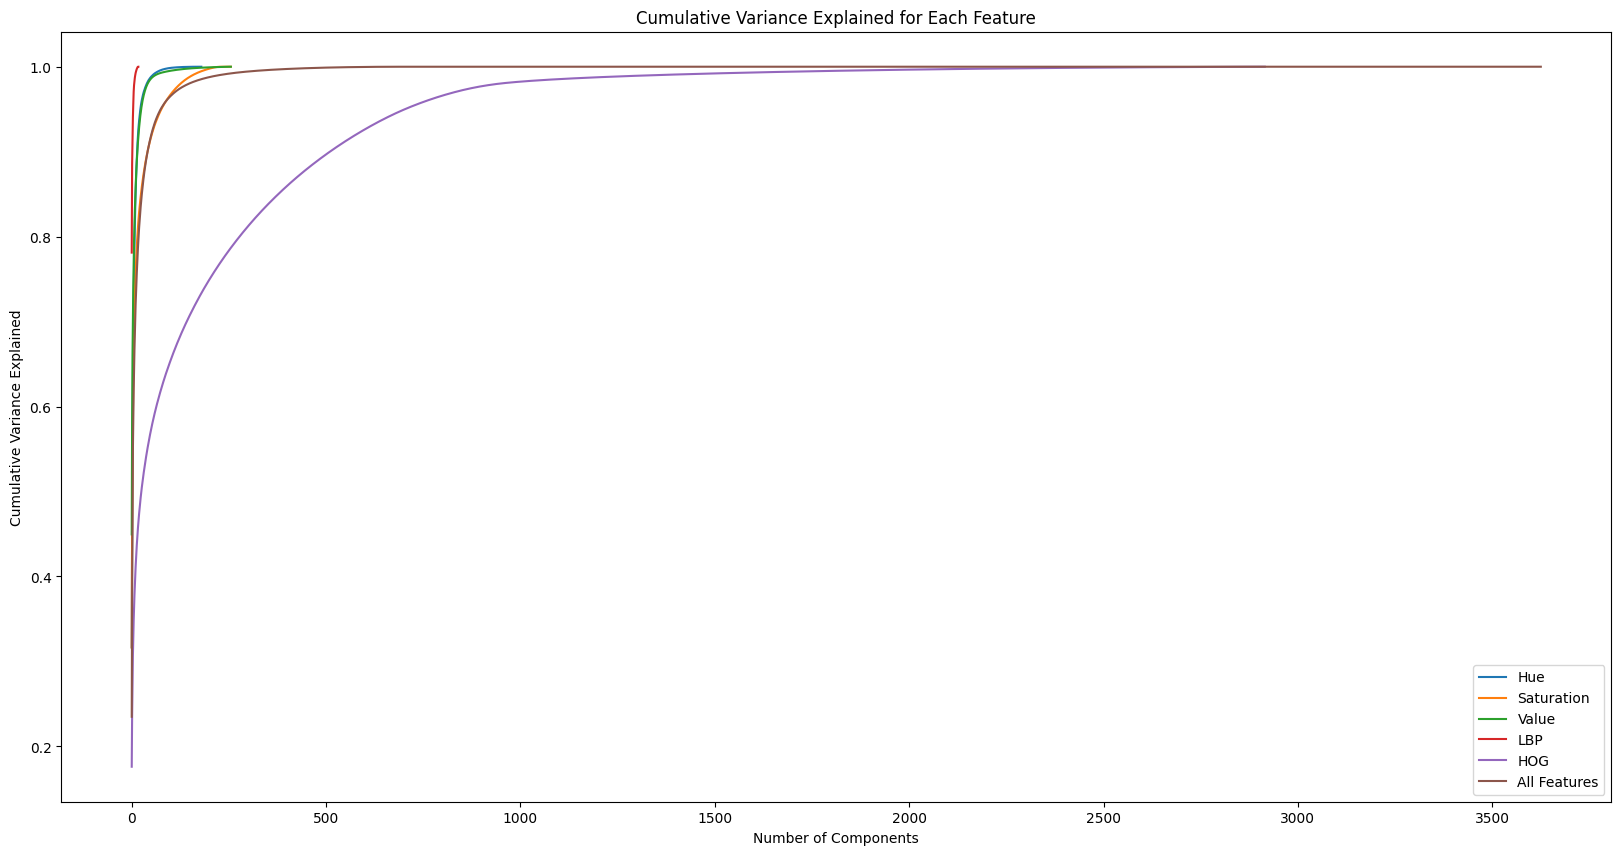

In [9]:
# plot variance explained of all features

variance_list = [hue_variance, saturation_variance, value_variance, lbp_variance, hog_variance, total_variance]
title = ["Hue", "Saturation", "Value", "LBP", "HOG", "All Features"]

def plot_variance_visual (variance_list, title):
    # define figure size and subplots
    fig = plt.figure(figsize=(20, 10))
    # plot the cumulative variance explained for each feature in the same plot
    for i in range(len(variance_list)):
        plt.plot(variance_list[i][1], label=title[i])
    plt.legend()
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance Explained")
    plt.title("Cumulative Variance Explained for Each Feature")
    plt.show()

plot_variance_visual (variance_list, title)

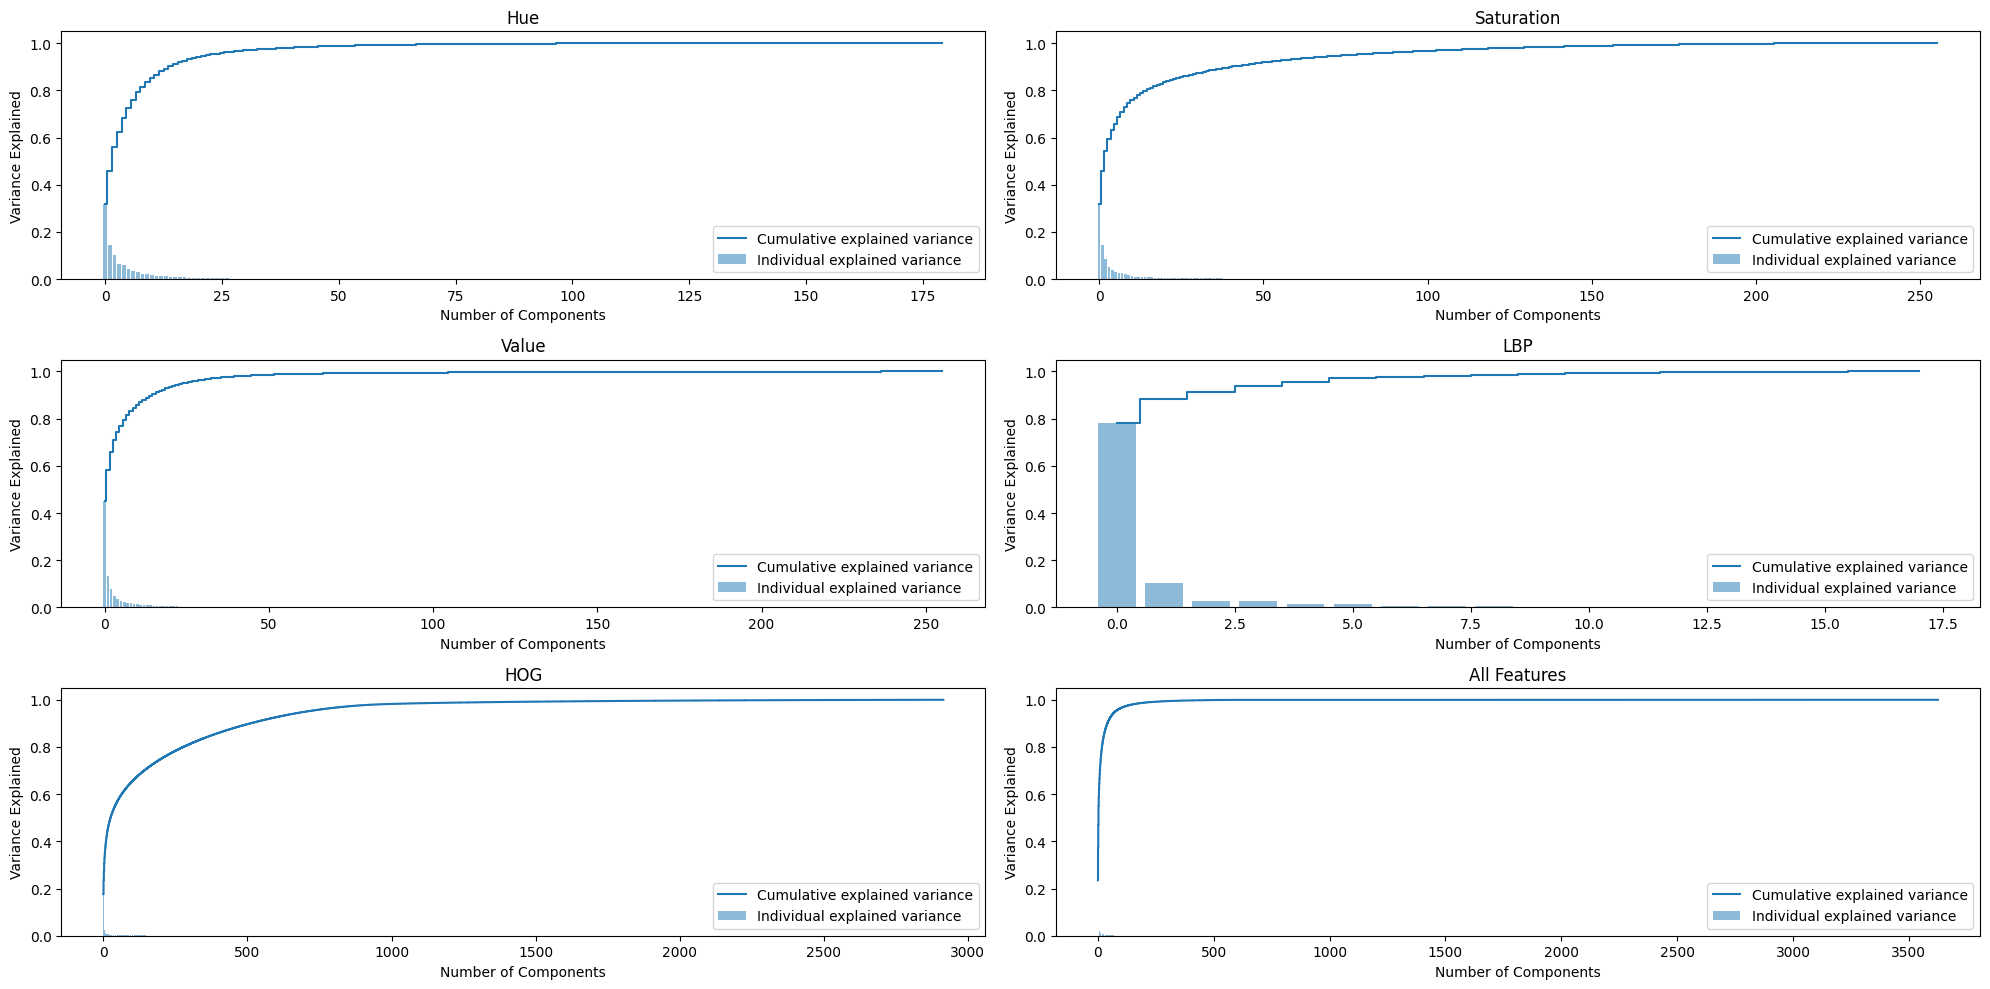

In [10]:
# create 6 subplots for each feature, 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
for i in range(len(variance_list)):
    axes[i//2, i%2].bar(range(0,len(variance_list[i][0])), variance_list[i][0], alpha=0.5, align='center', label='Individual explained variance')
    # add step graph to plot cumulative variance explained
    axes[i//2, i%2].step(range(0,len(variance_list[i][1])), variance_list[i][1], where='mid',label='Cumulative explained variance')
    # add legend
    axes[i//2, i%2].legend(loc='best')
    # add title
    axes[i//2, i%2].set_title(title[i])
    axes[i//2, i%2].set_xlabel("Number of Components")
    axes[i//2, i%2].set_ylabel("Variance Explained")

plt.tight_layout()
plt.show()



In [11]:
# select the top components in features_total that explain 95% of the variance
pca = PCA(n_components=0.95)
pca.fit(features_total)
print("Number of components that explain 95% of the variance:", pca.n_components_)
features_total_pca = pca.transform(features_total)
print("Shape of features_total_pca:", features_total_pca.shape)


Number of components that explain 95% of the variance: 76
Shape of features_total_pca: (39209, 76)


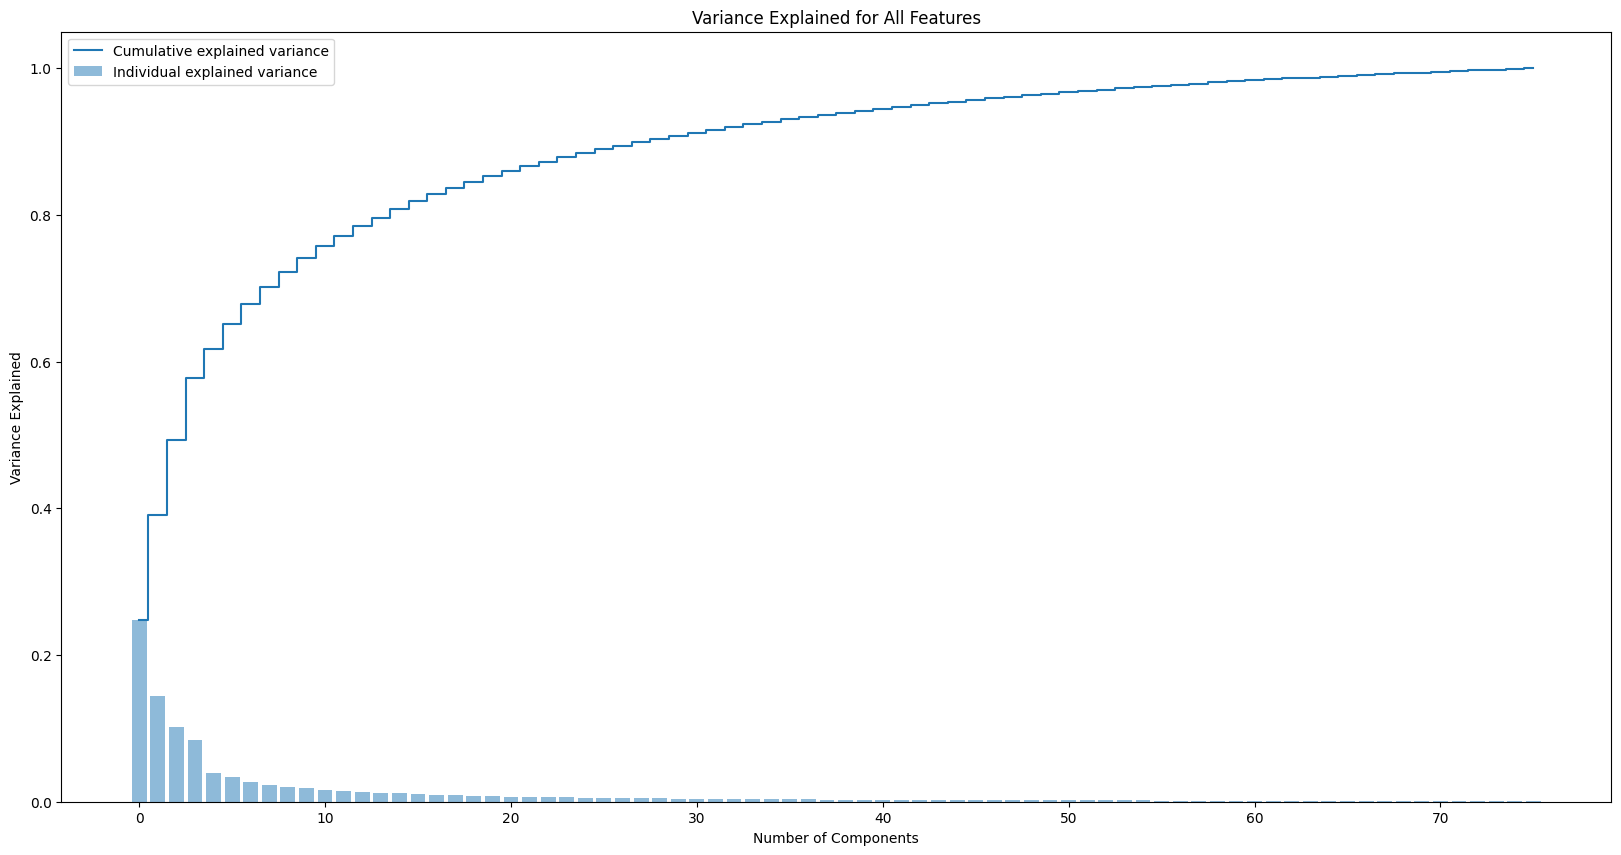

In [12]:
total_variance_pca = get_variance_explained(features_total_pca)

# plot individual and cumulative variance explained
fig = plt.figure(figsize=(20, 10))
plt.bar(range(0,len(total_variance_pca[0])), total_variance_pca[0], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(total_variance_pca[1])), total_variance_pca[1], where='mid',label='Cumulative explained variance')
plt.legend(loc='best')
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.title("Variance Explained for All Features")
plt.show()



#### Observation:

- In the 6 plots above, HOG and Satuation take a larger number of features to get to 80% variance explained
- Try removing HOG and Satuation feature to construct a new reduced total feature file

In [13]:
# remove HOG and Saturation features, only keep Hue, Value, and LBP
features_total_reduced = np.hstack([hue, value, lbp])
features_total_reduced.shape

(39209, 454)

In [14]:
    pca = PCA()  # did not specify number of components
    pca.fit(features_total_reduced)
    individual_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    individual_variance.shape

(454,)

In [15]:
total_variance_reduced = get_variance_explained(features_total_reduced)
total_variance_reduced[0].shape

(454,)

In [16]:
# total_variance_reduced = get_variance_explained(features_total_reduced)

# pick the top 95% variance explained
pca = PCA(n_components=0.95)
pca.fit(features_total_reduced)
print("Number of components that explain 95% of the variance:", pca.n_components_)
features_total_reduced_pca = pca.transform(features_total_reduced)
print("Shape of features_total_reduced_pca:", features_total_reduced_pca.shape)


Number of components that explain 95% of the variance: 51
Shape of features_total_reduced_pca: (39209, 51)


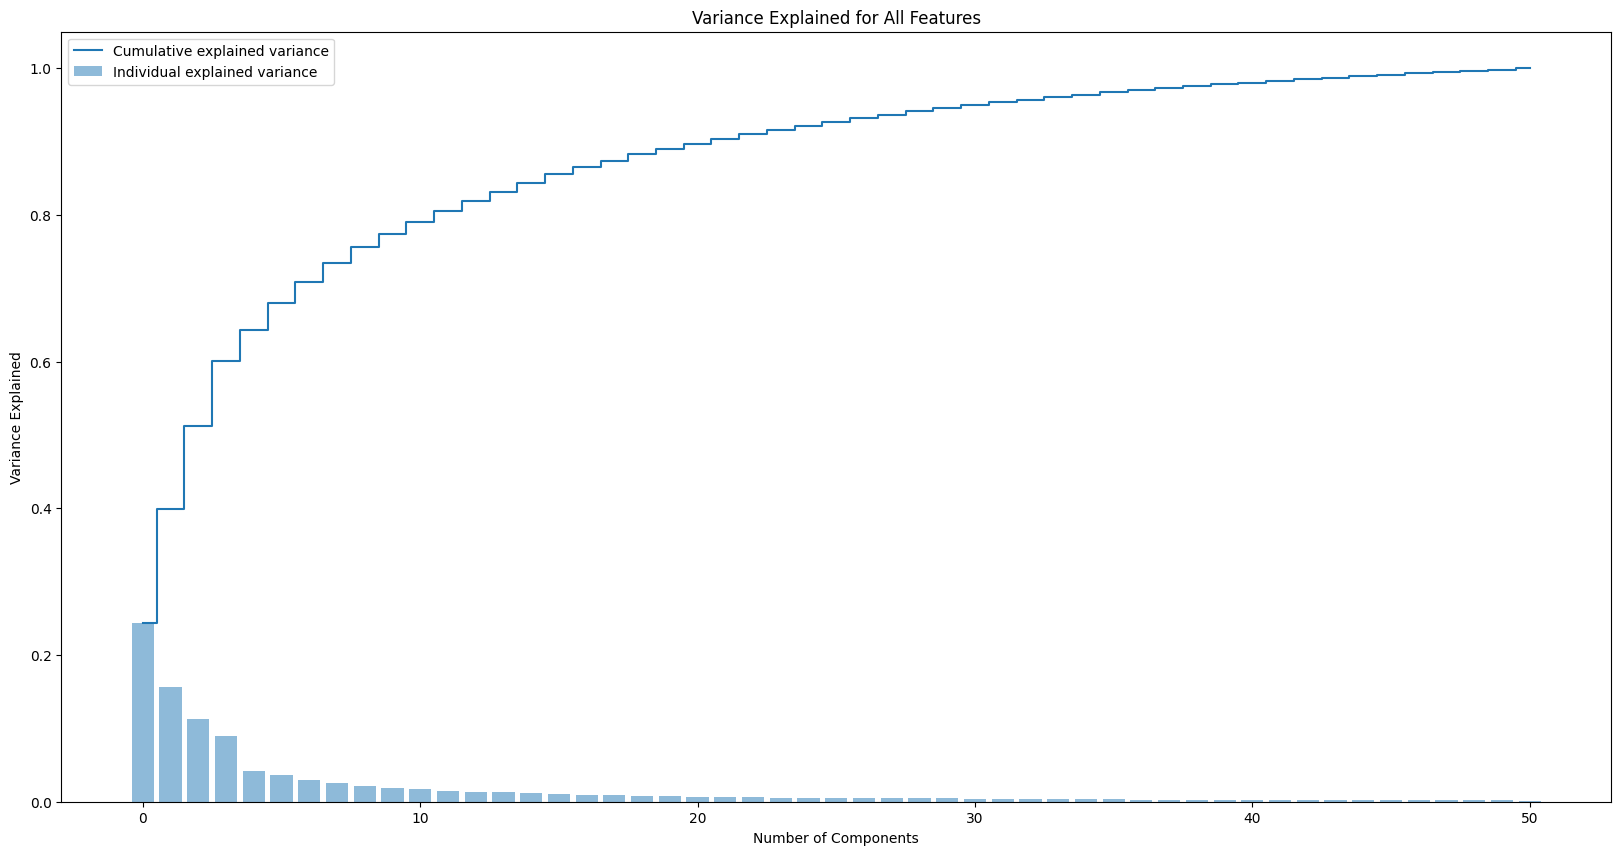

In [17]:
total_variance_reduced_pca = get_variance_explained(features_total_reduced_pca)

# plot individual and cumulative variance explained
fig = plt.figure(figsize=(20, 10))
plt.bar(range(0,len(total_variance_reduced_pca[0])), total_variance_reduced_pca[0], alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(total_variance_reduced_pca[1])), total_variance_reduced_pca[1], where='mid',label='Cumulative explained variance')
plt.legend(loc='best')
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")
plt.title("Variance Explained for All Features")
plt.show()

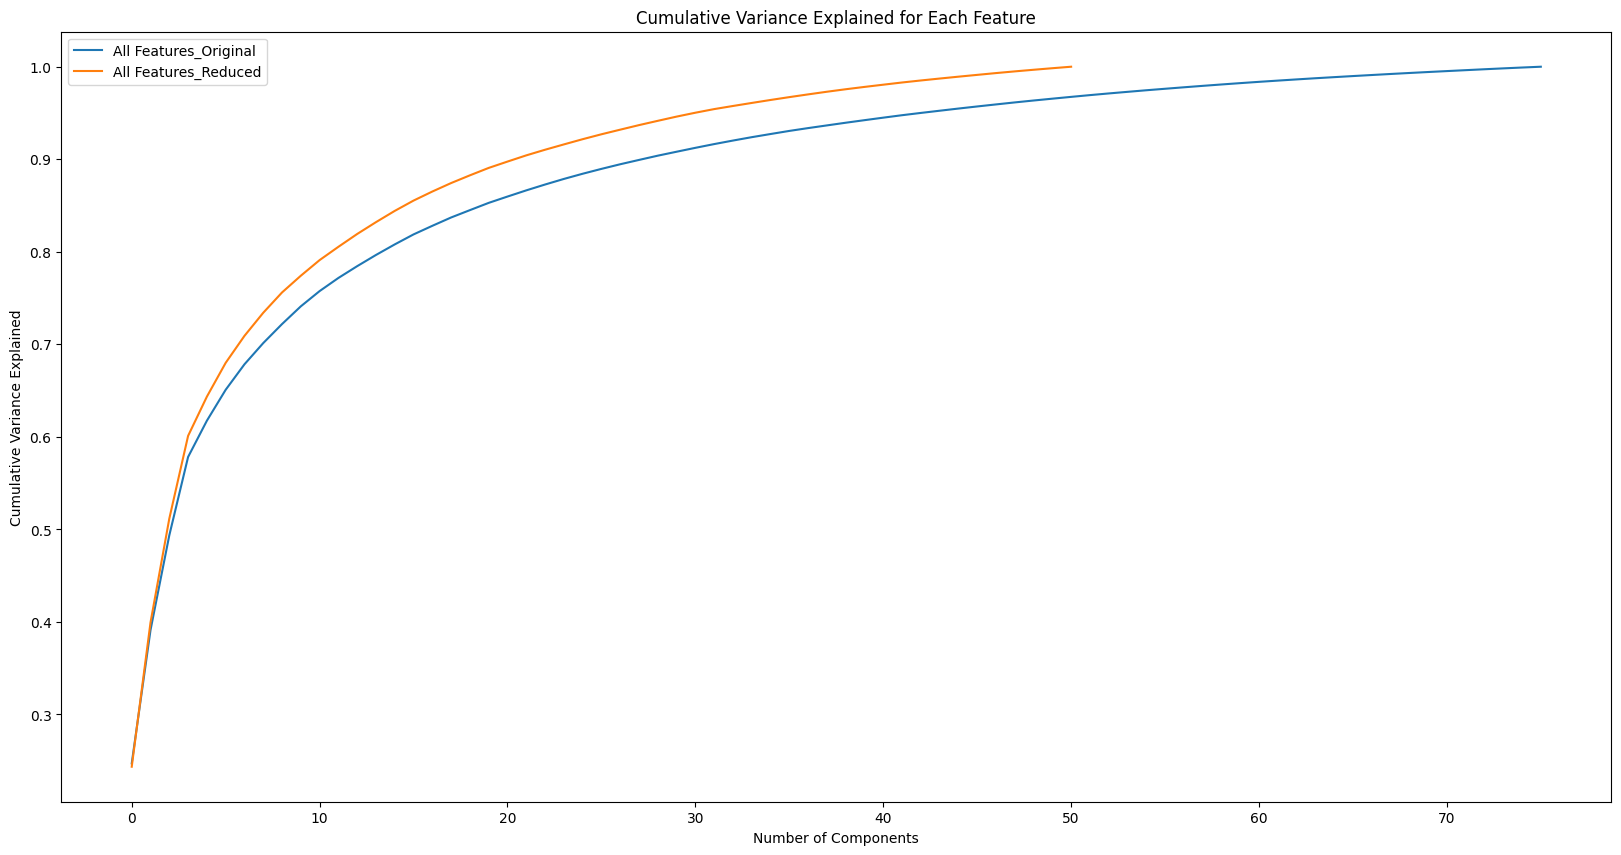

In [18]:
# after reducing the top 95% features, compare the variance explained for all features and reduced features

variance_list_2 = [total_variance_pca, total_variance_reduced_pca]
title_2 = ["All Features_Original", "All Features_Reduced"]

# def plot_variance_visual (variance_list, title):
#     # define figure size and subplots
#     fig = plt.figure(figsize=(20, 10))
#     # plot the cumulative variance explained for each feature in the same plot
#     for i in range(len(variance_list)):
#         plt.plot(variance_list[i][1], label=title[i])
#     plt.legend()
#     plt.xlabel("Number of Components")
#     plt.ylabel("Cumulative Variance Explained")
#     plt.title("Cumulative Variance Explained for Each Feature")
#     plt.show()

plot_variance_visual (variance_list_2, title_2)

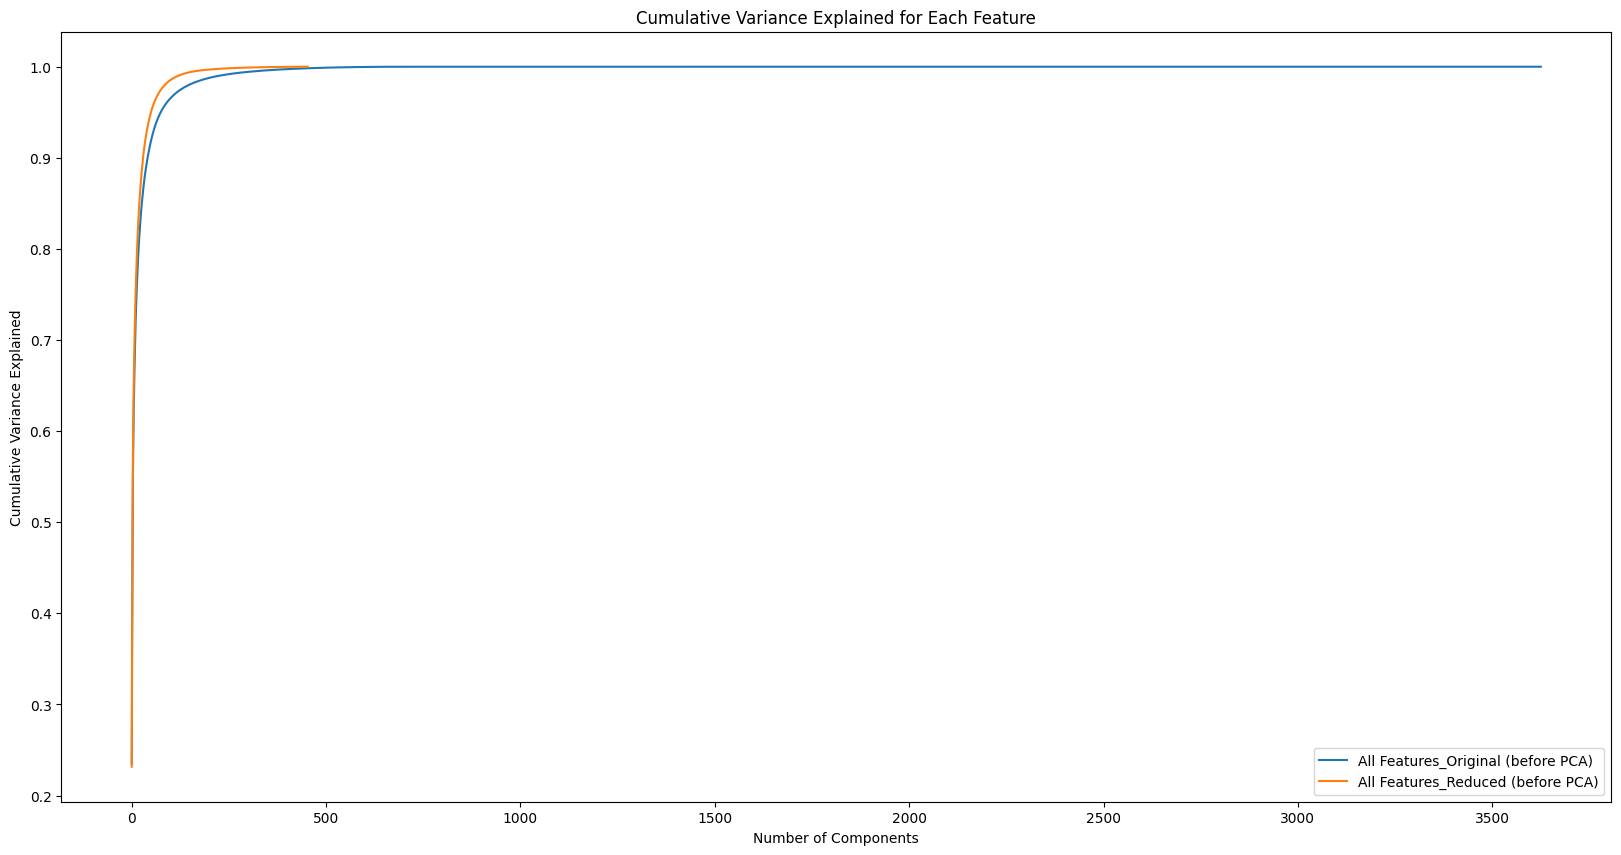

In [19]:
# BEFORE reducing the top 95% features, compare the variance explained for all features and reduced features

variance_list_before = [total_variance, total_variance_reduced]
title_before = ["All Features_Original (before PCA)", "All Features_Reduced (before PCA)"]

plot_variance_visual (variance_list_before, title_before)


### Check Features images   [from Ed's Check Features.ipynb]

Class: 0 Description: Max limit (20 km/h)


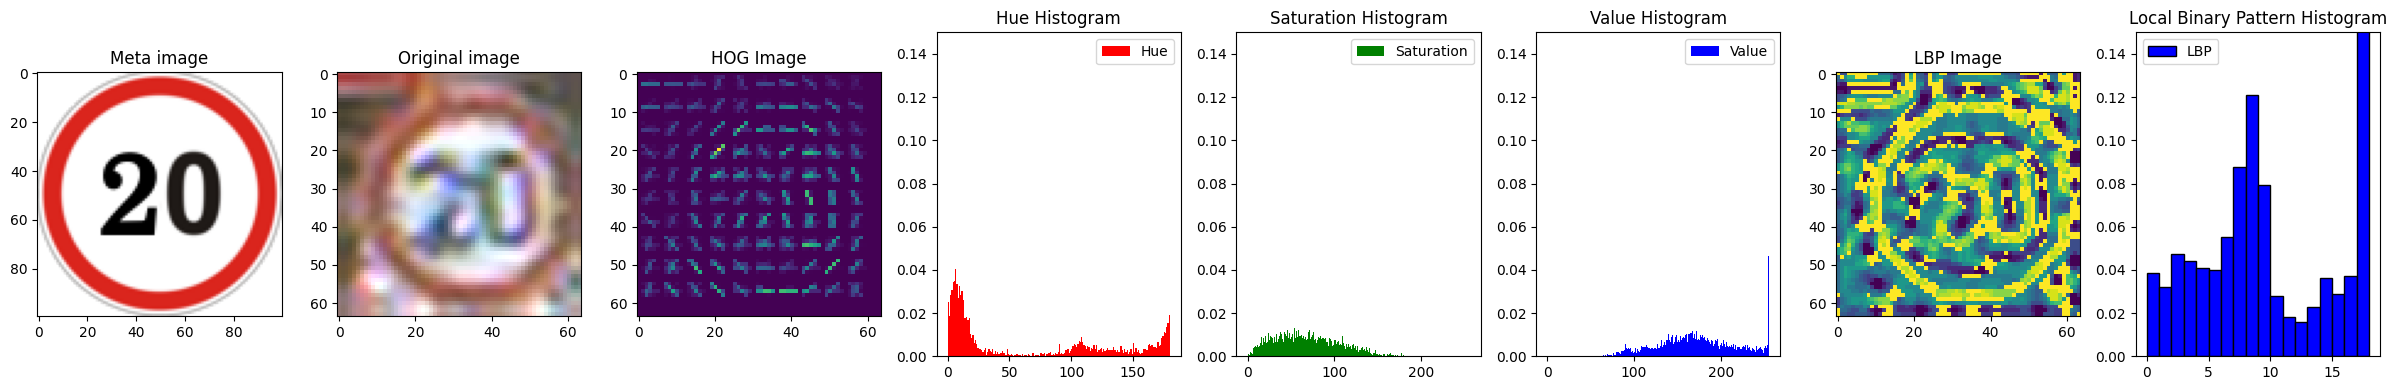

Class: 1 Description: Max limit (30 km/h)


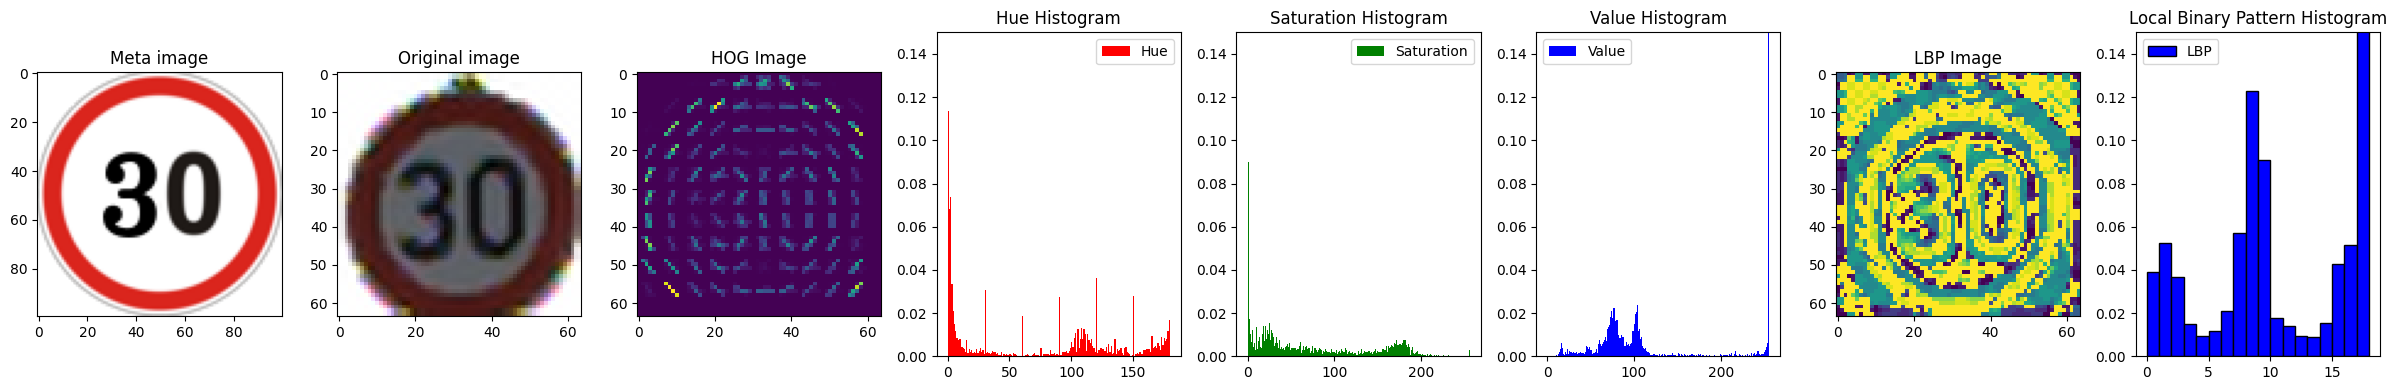

Class: 2 Description: Max limit (50 km/h)


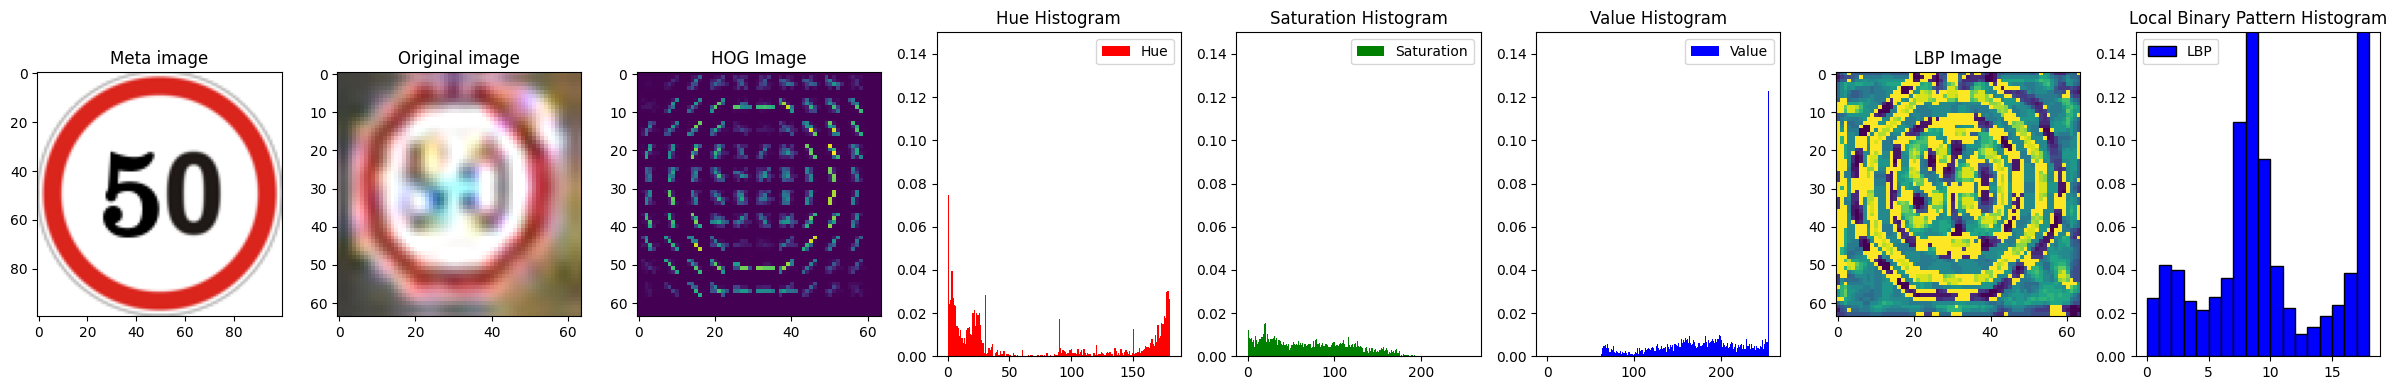

Class: 3 Description: Max limit (60 km/h)


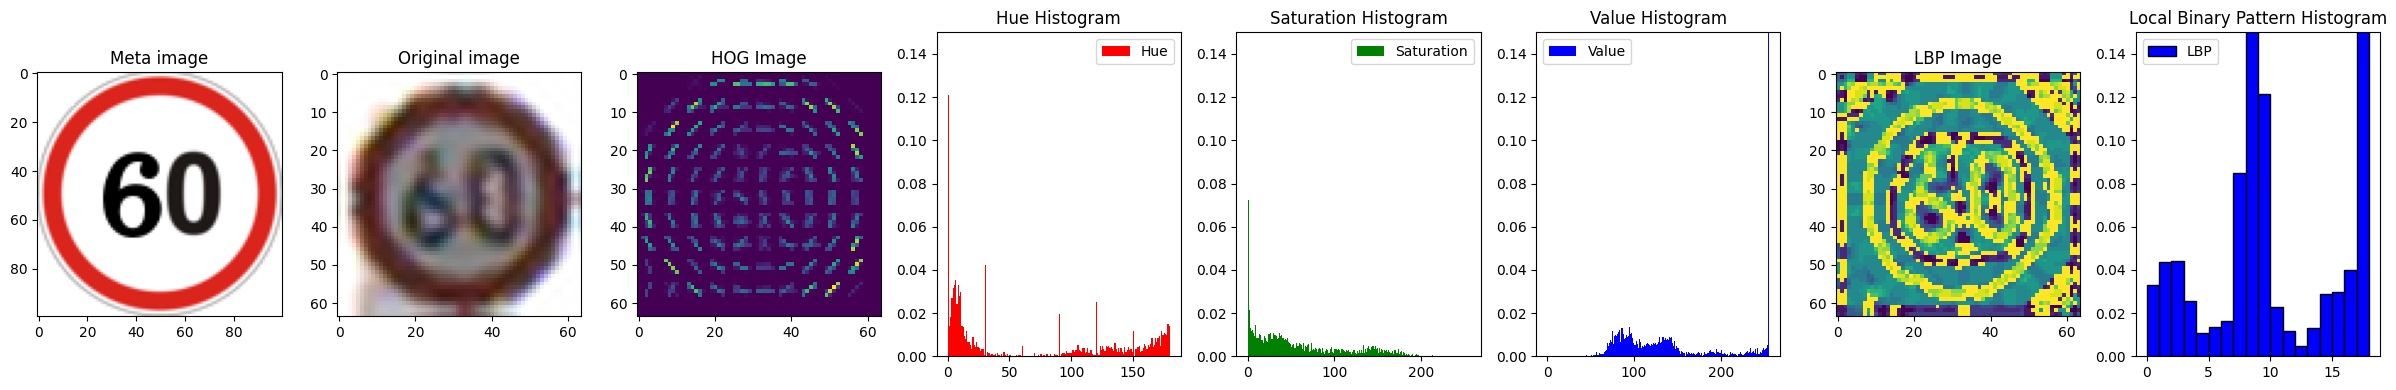

Class: 4 Description: Max limit (70 km/h)


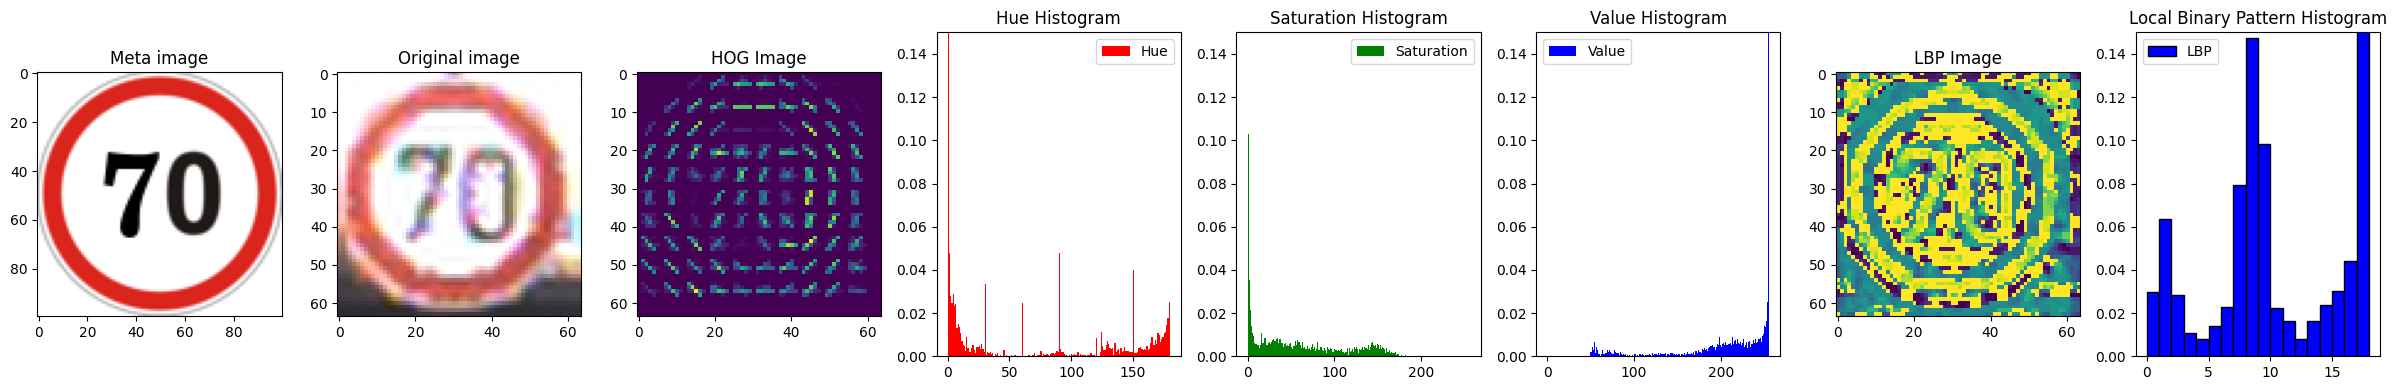

Class: 5 Description: Max limit (80 km/h)


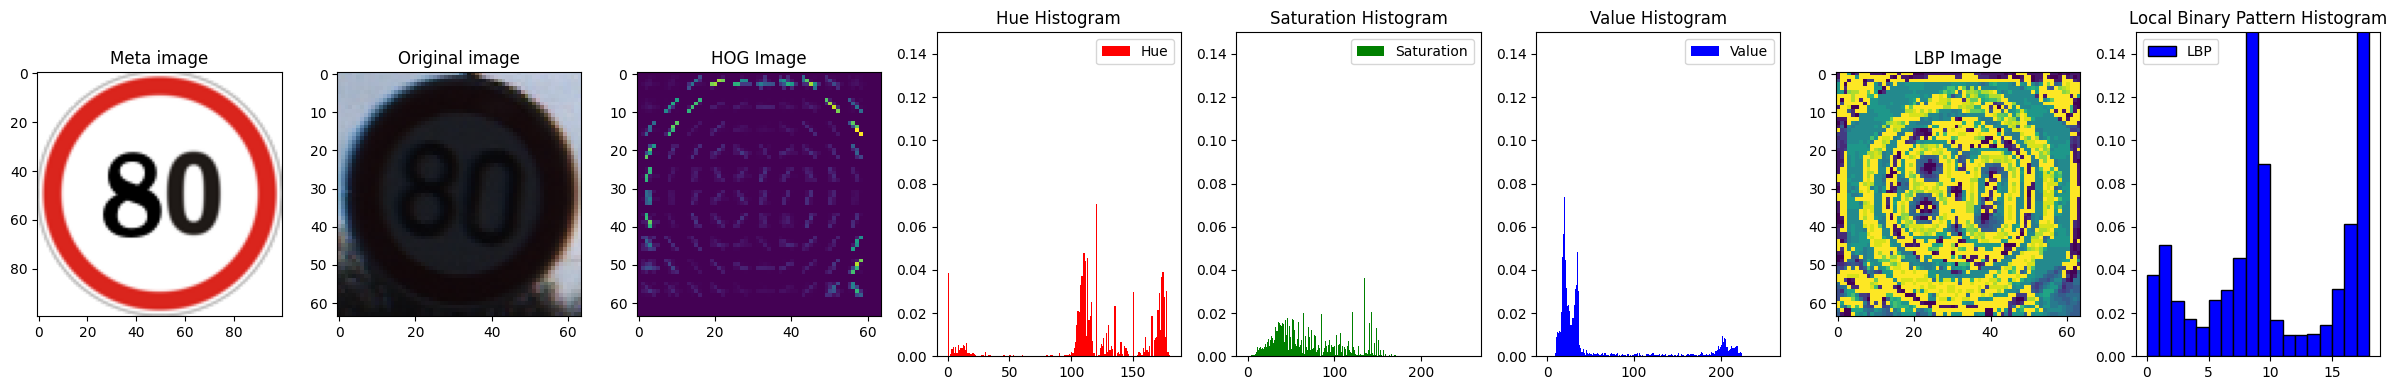

Class: 6 Description: End of limit (80 km/h)


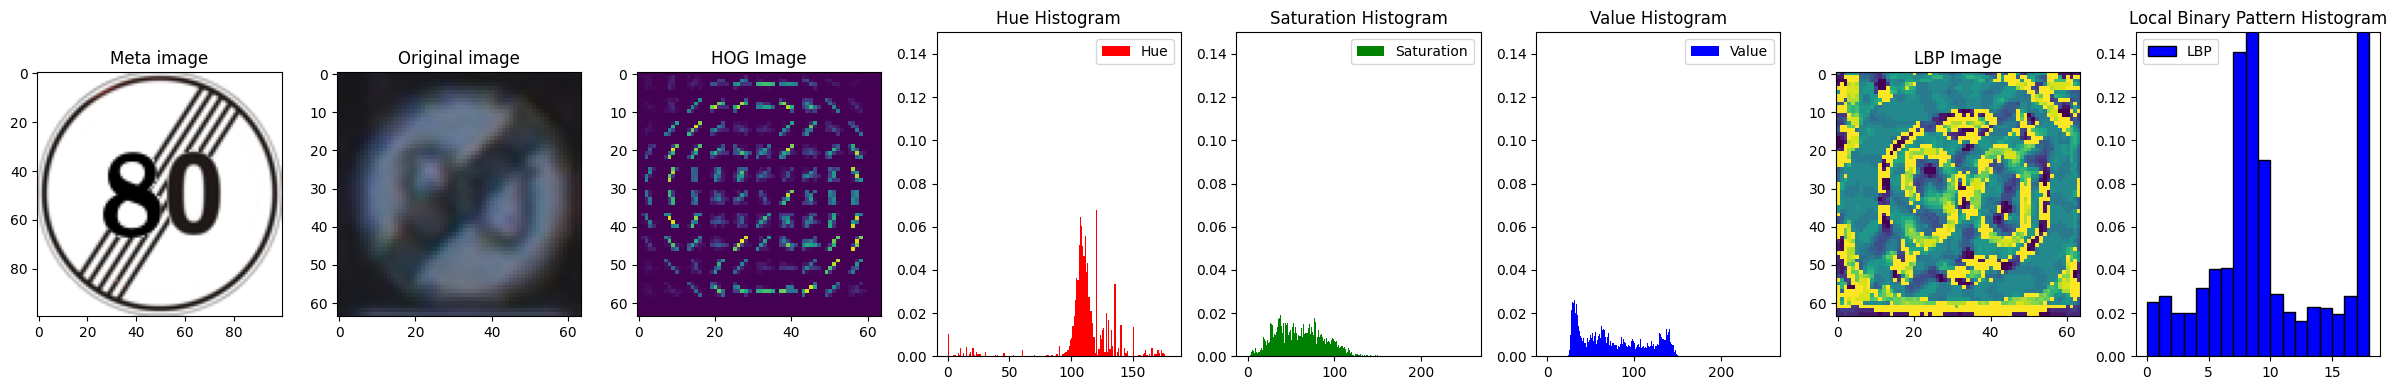

Class: 7 Description: Max limit (100 km/h)


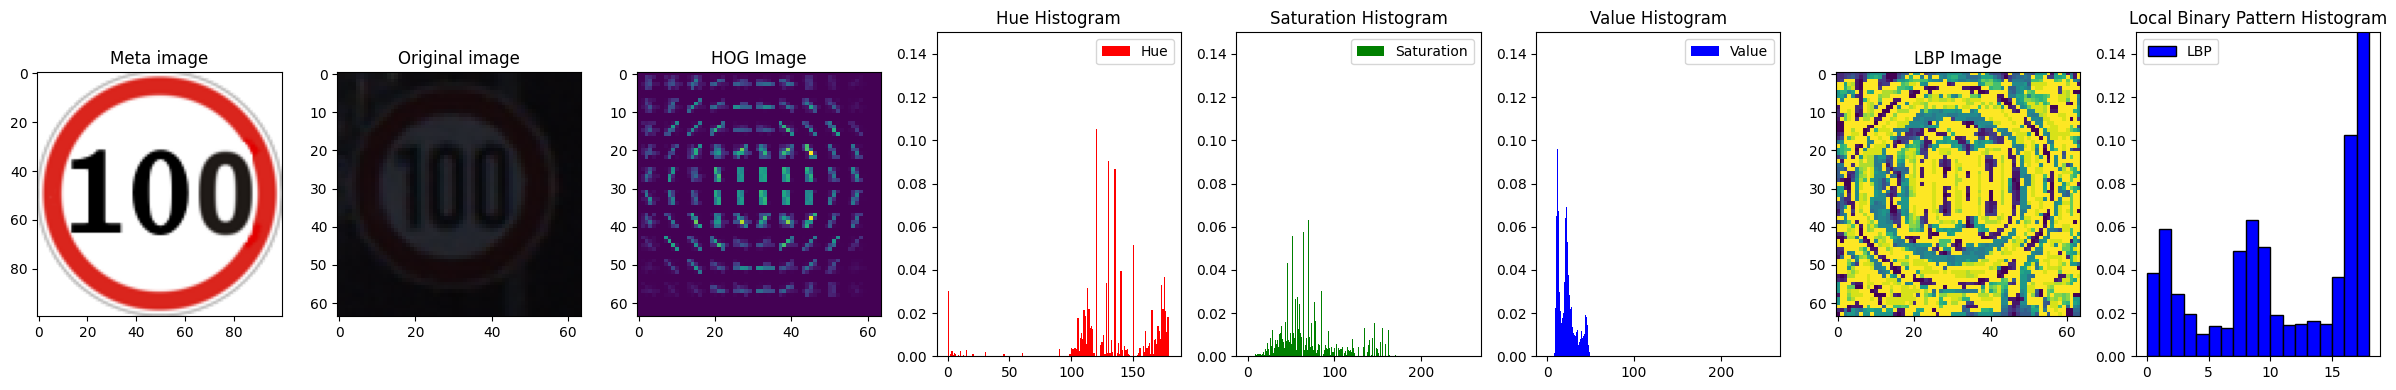

Class: 8 Description: Max limit (120 km/h)


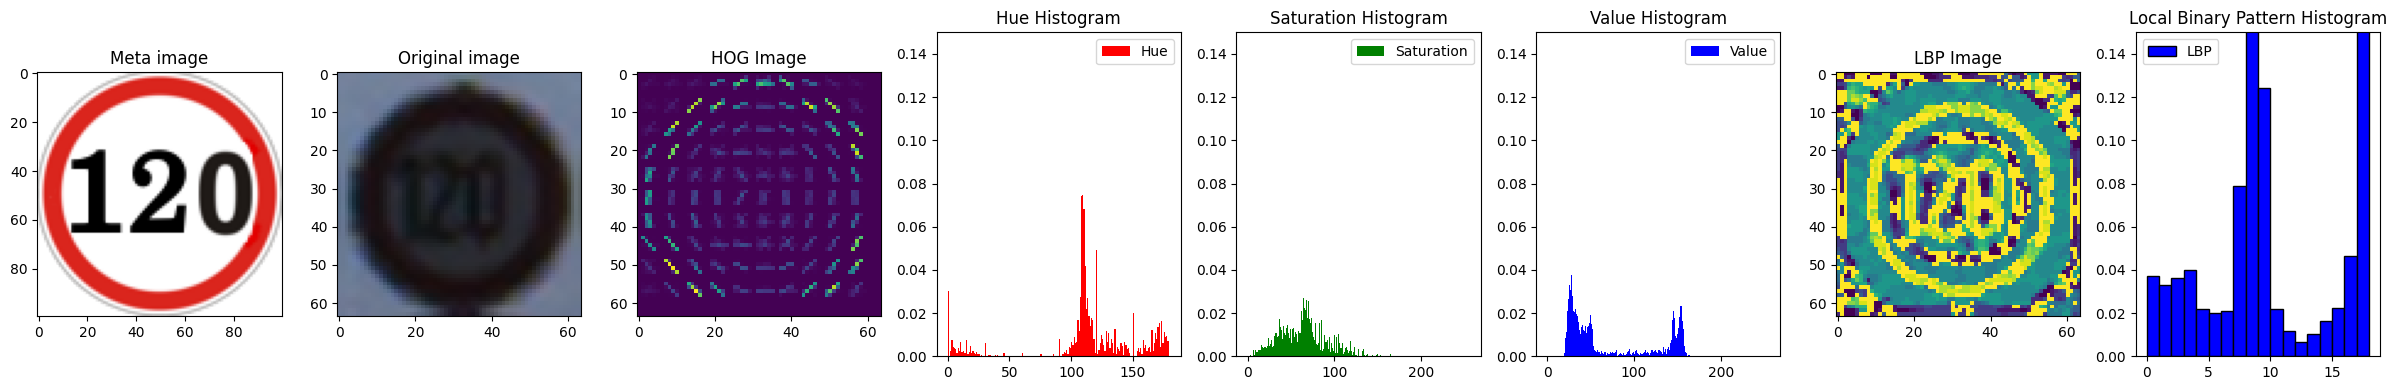

Class: 9 Description: No passing (except bike/mopeds/mcycles)


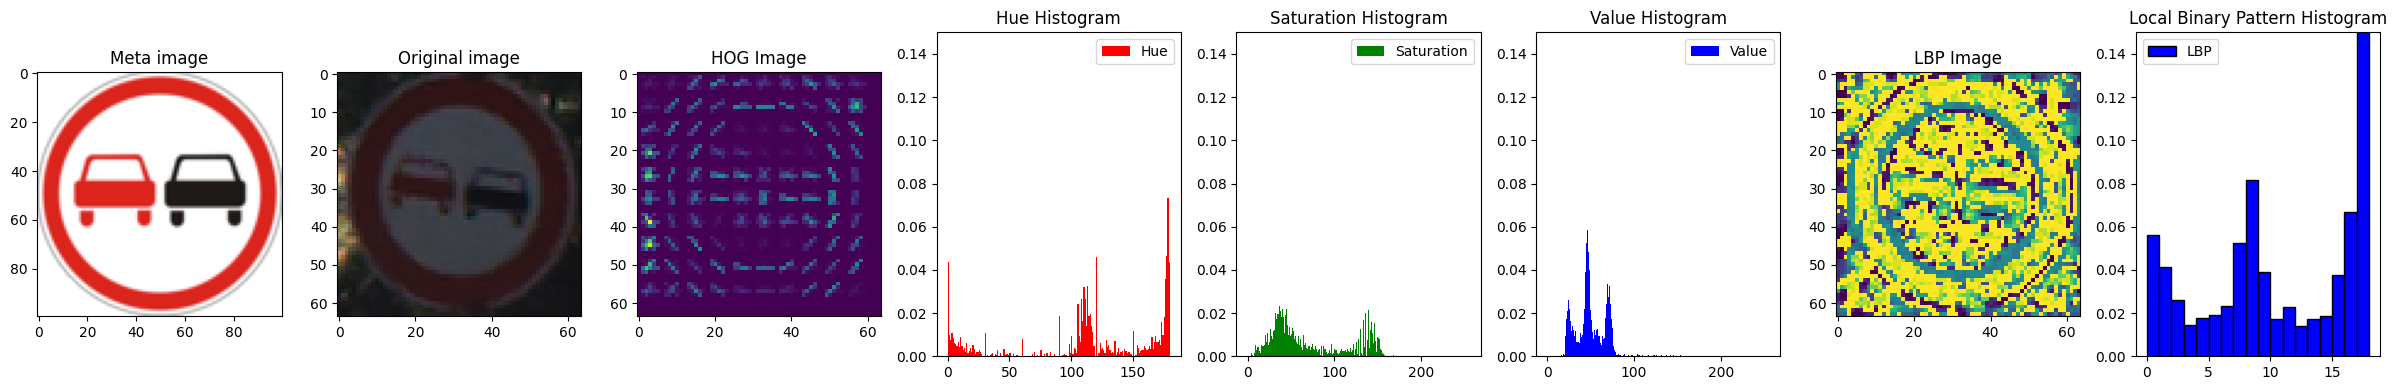

Class: 10 Description: No passing over 3.5  tons


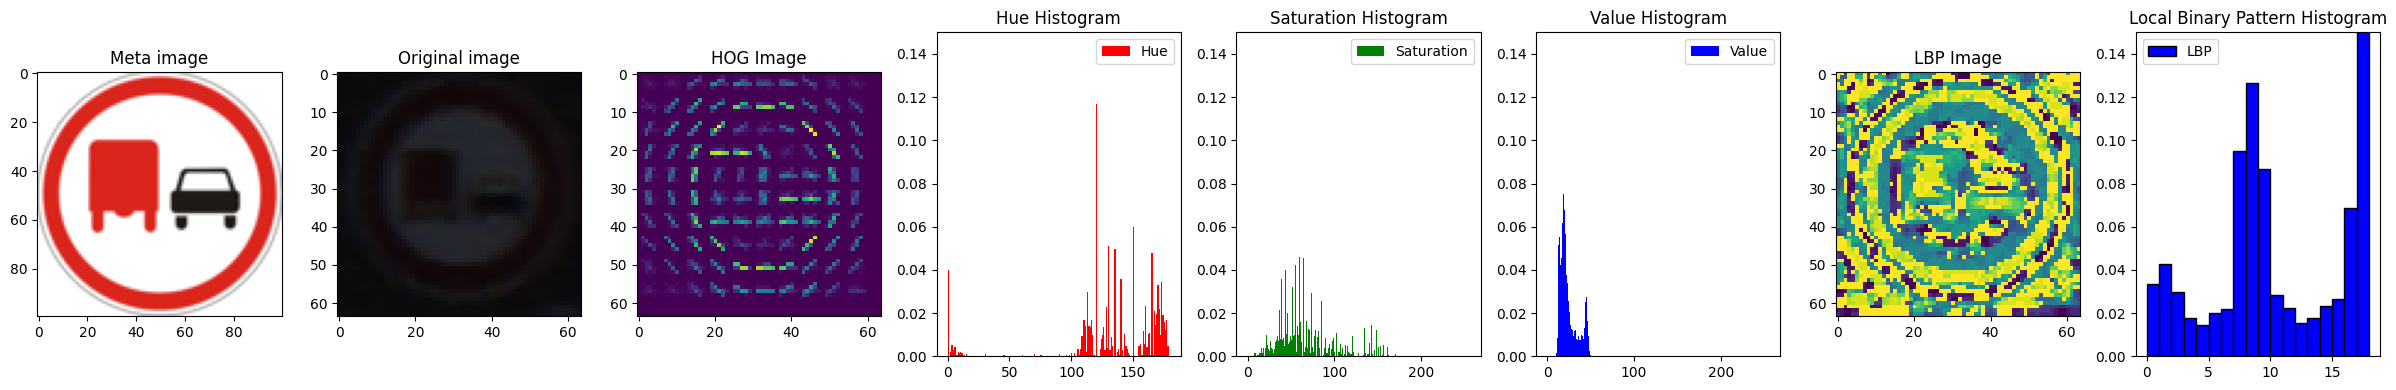

Class: 11 Description: Right of way at next intersection


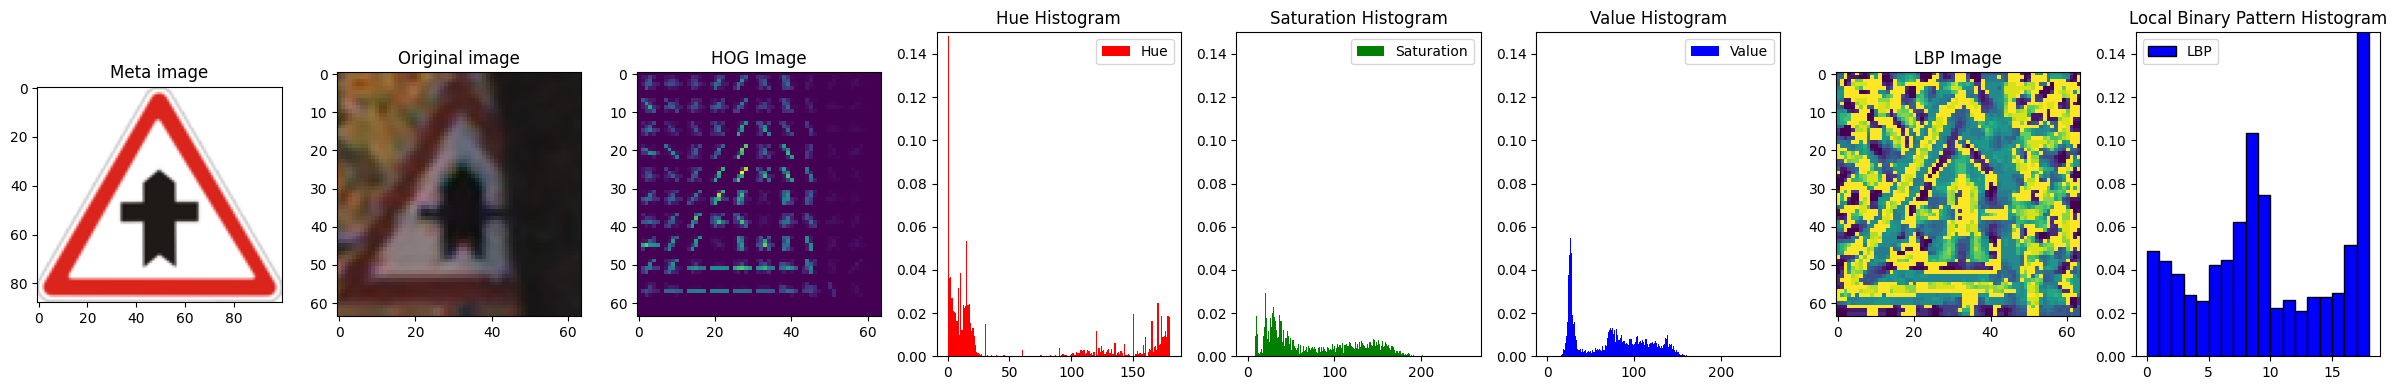

Class: 12 Description: Right of way at all intersections)


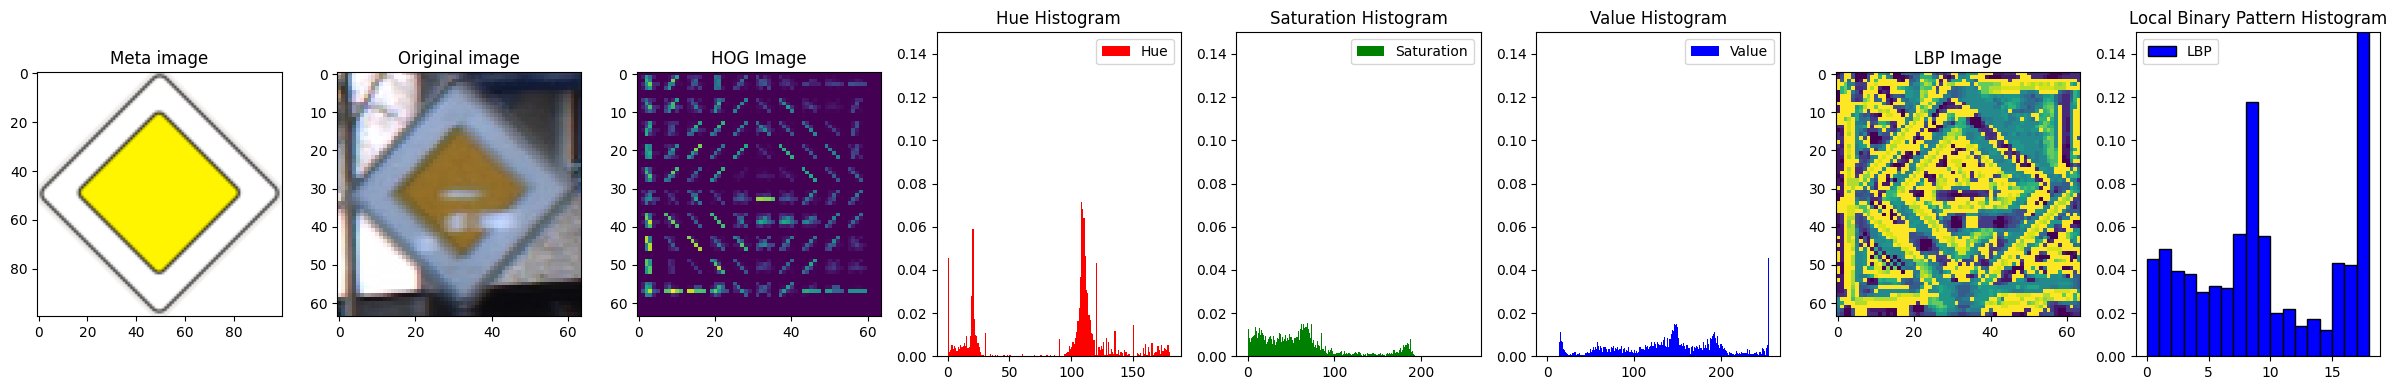

Class: 13 Description: Yield


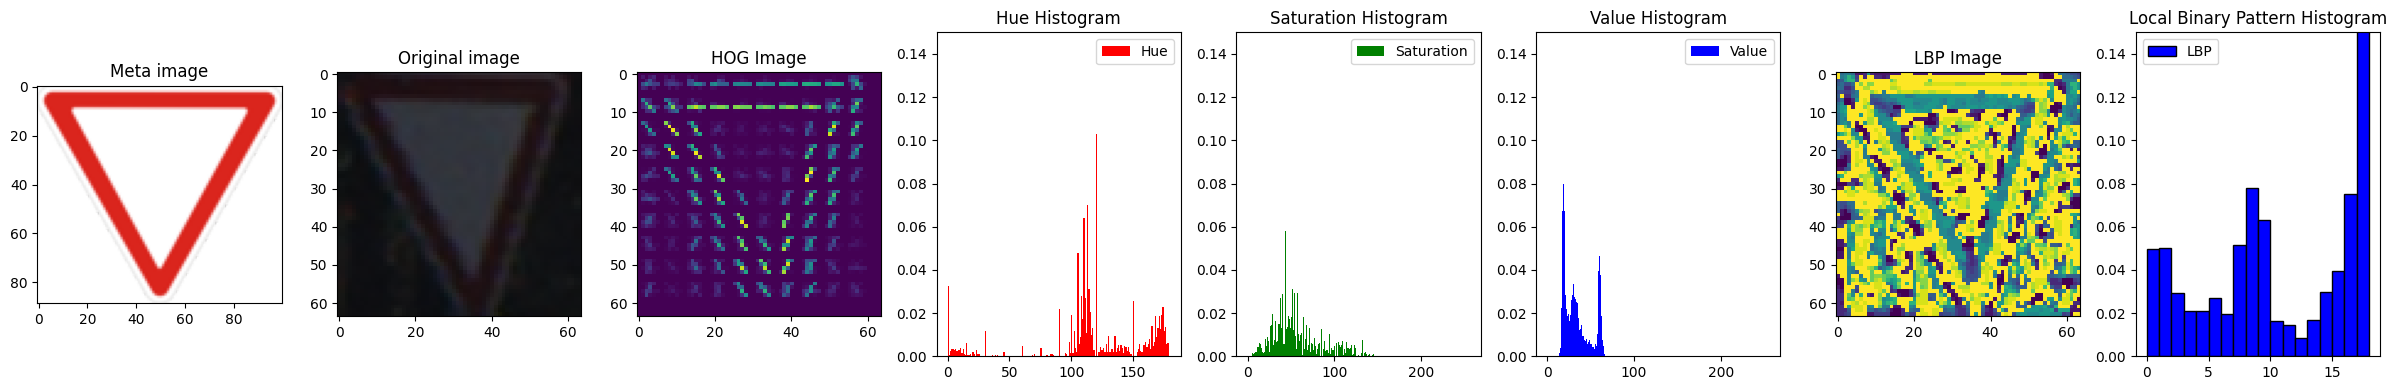

Class: 14 Description: Stop


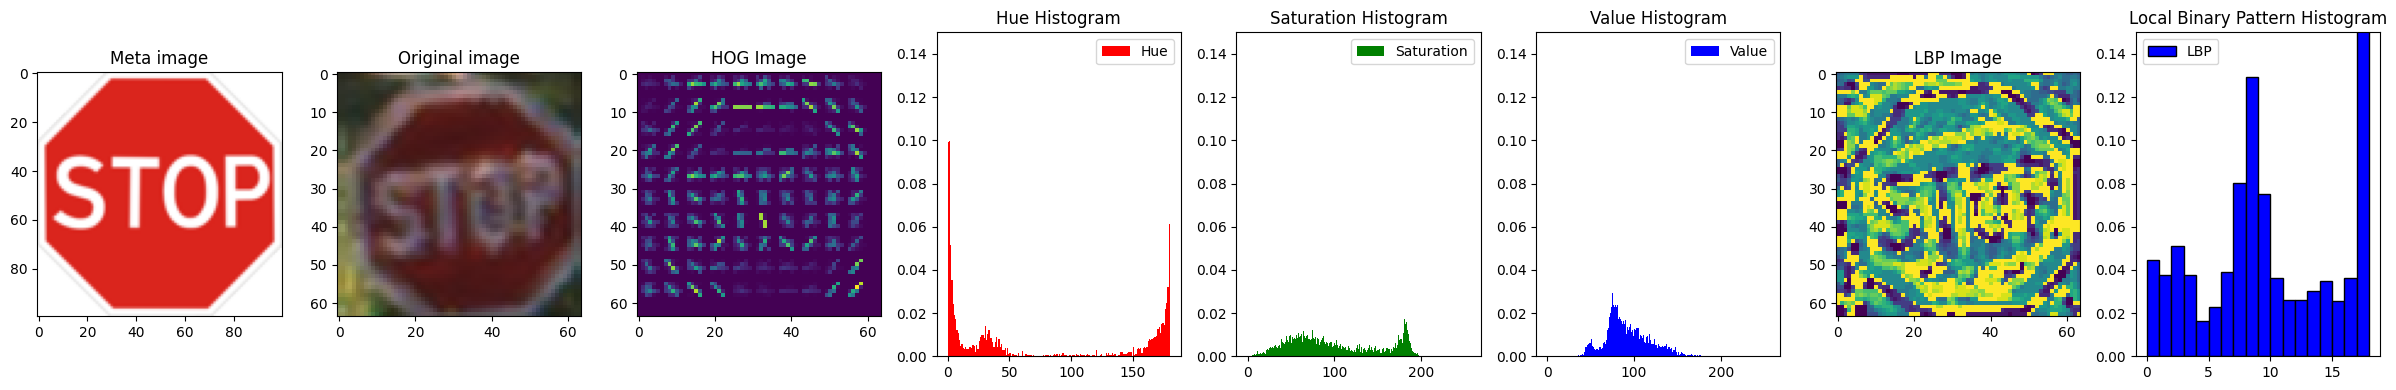

Class: 15 Description: Road closed


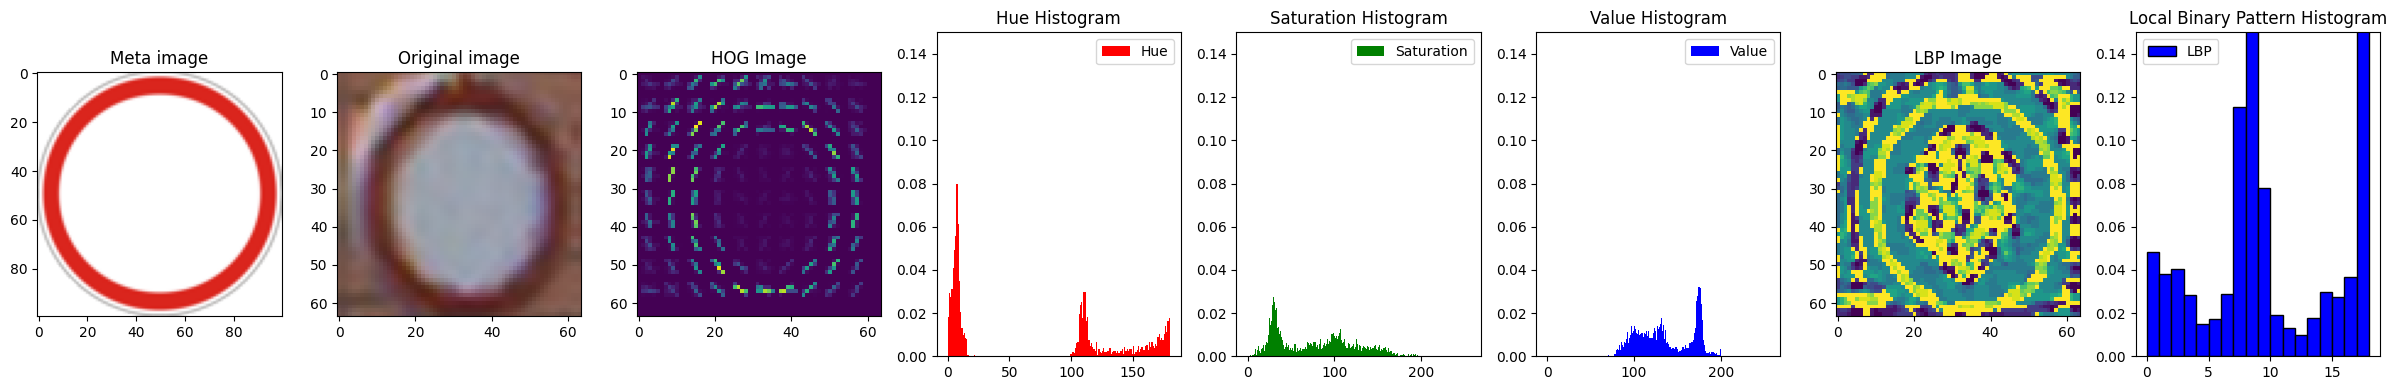

Class: 16 Description: Over 3.5 Tons prohibited


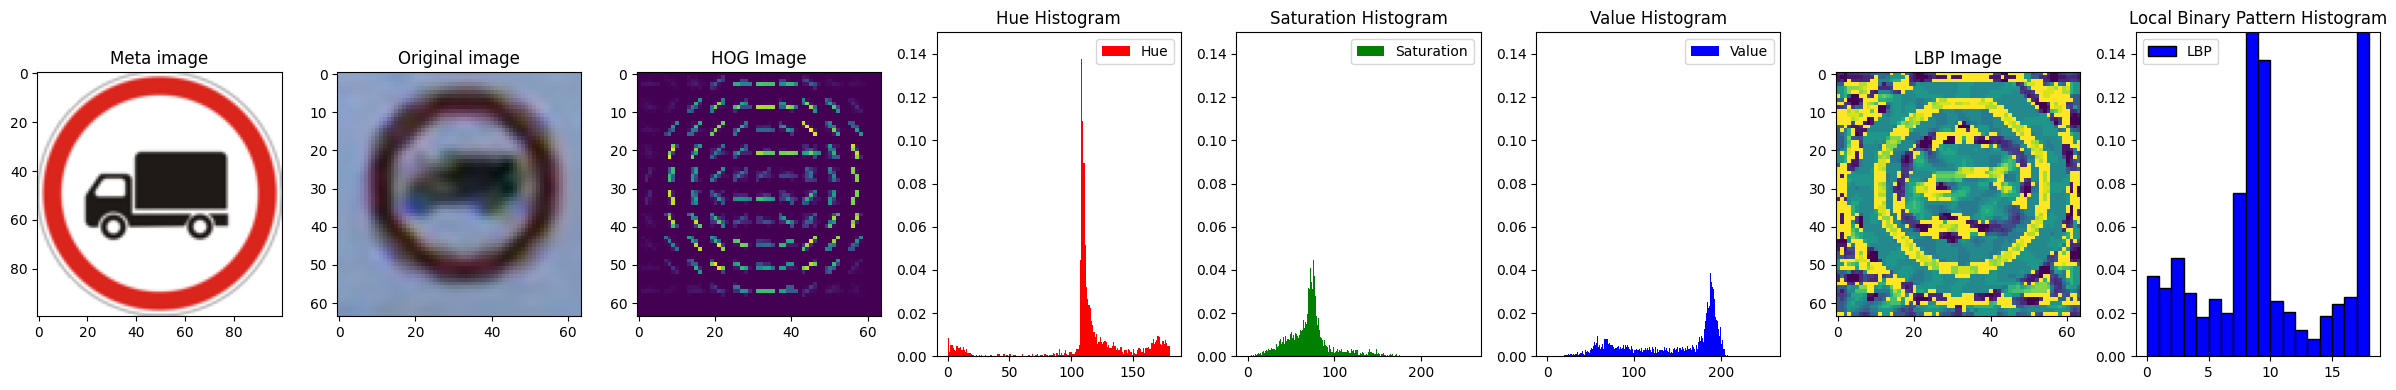

Class: 17 Description: Do not enter


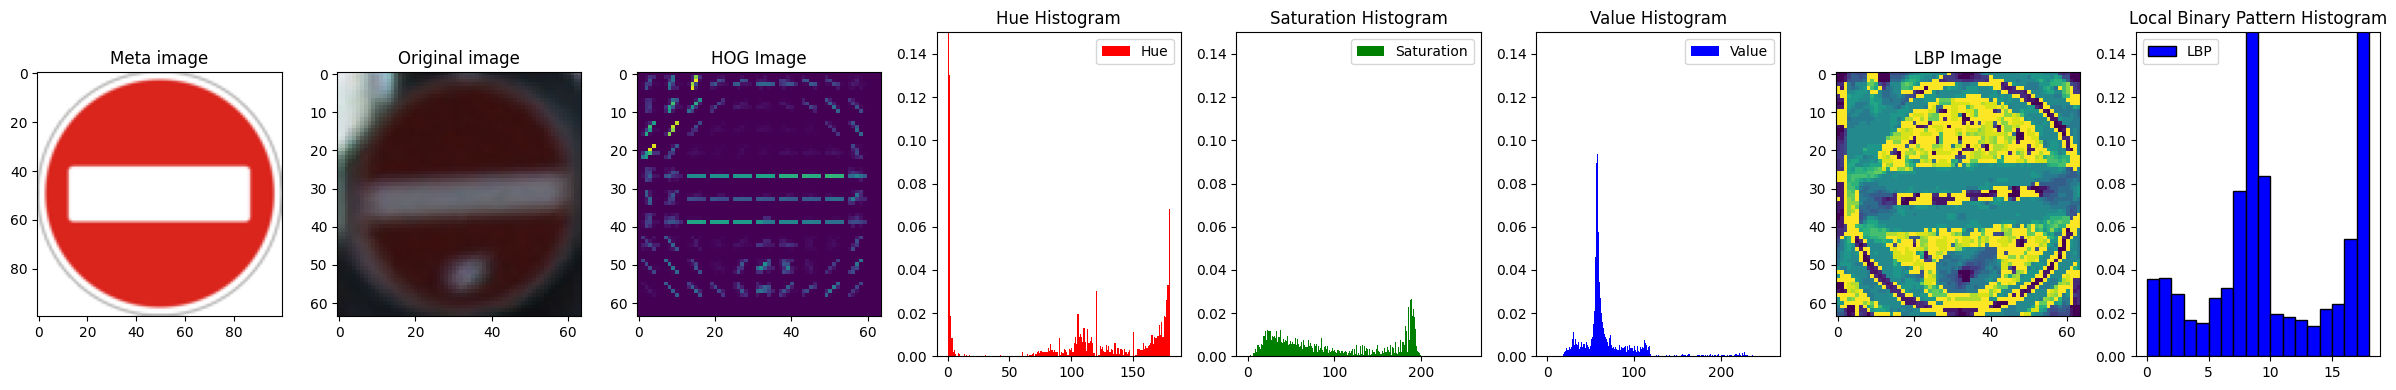

Class: 18 Description: General danger


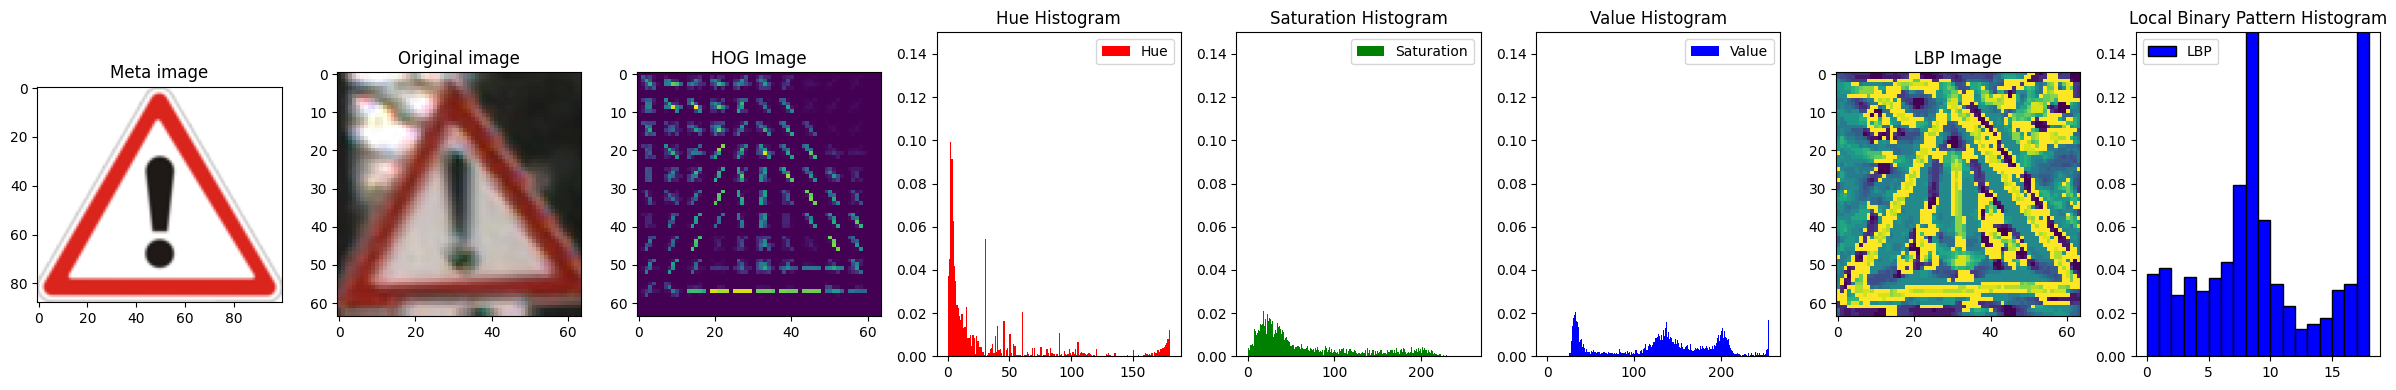

Class: 19 Description: Left curve


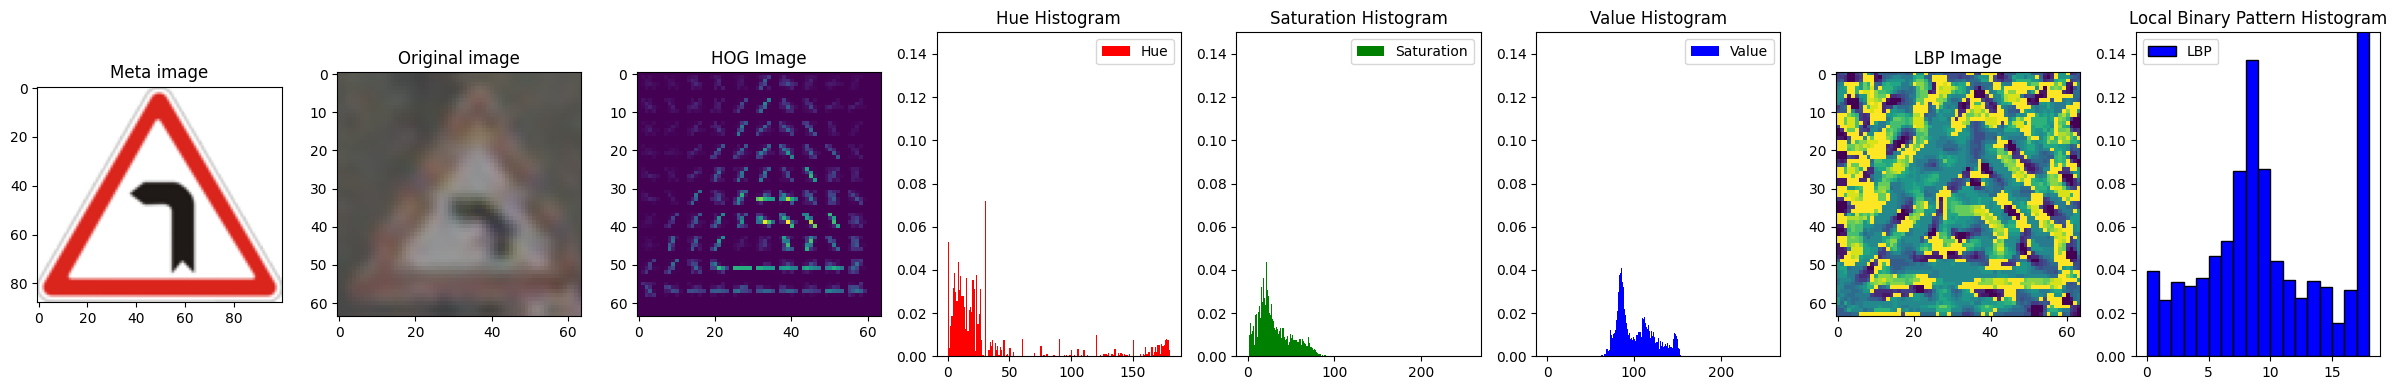

Class: 20 Description: Right curve


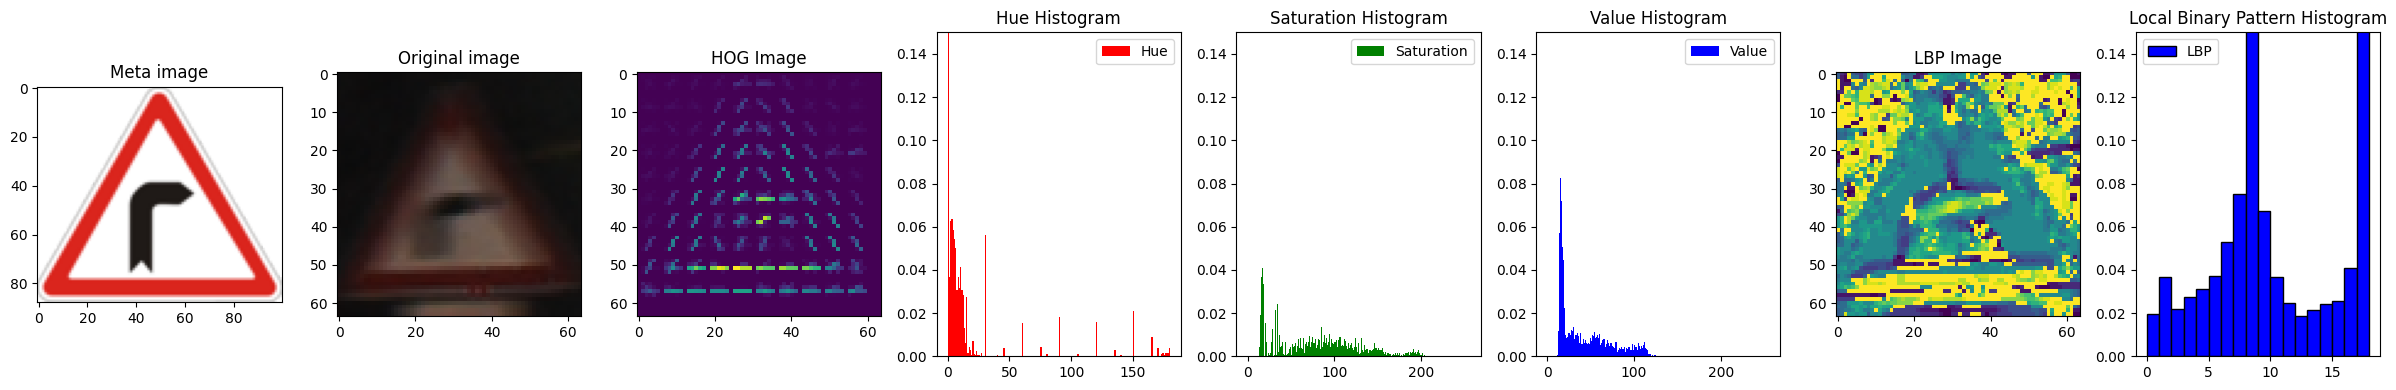

Class: 21 Description: Double curve


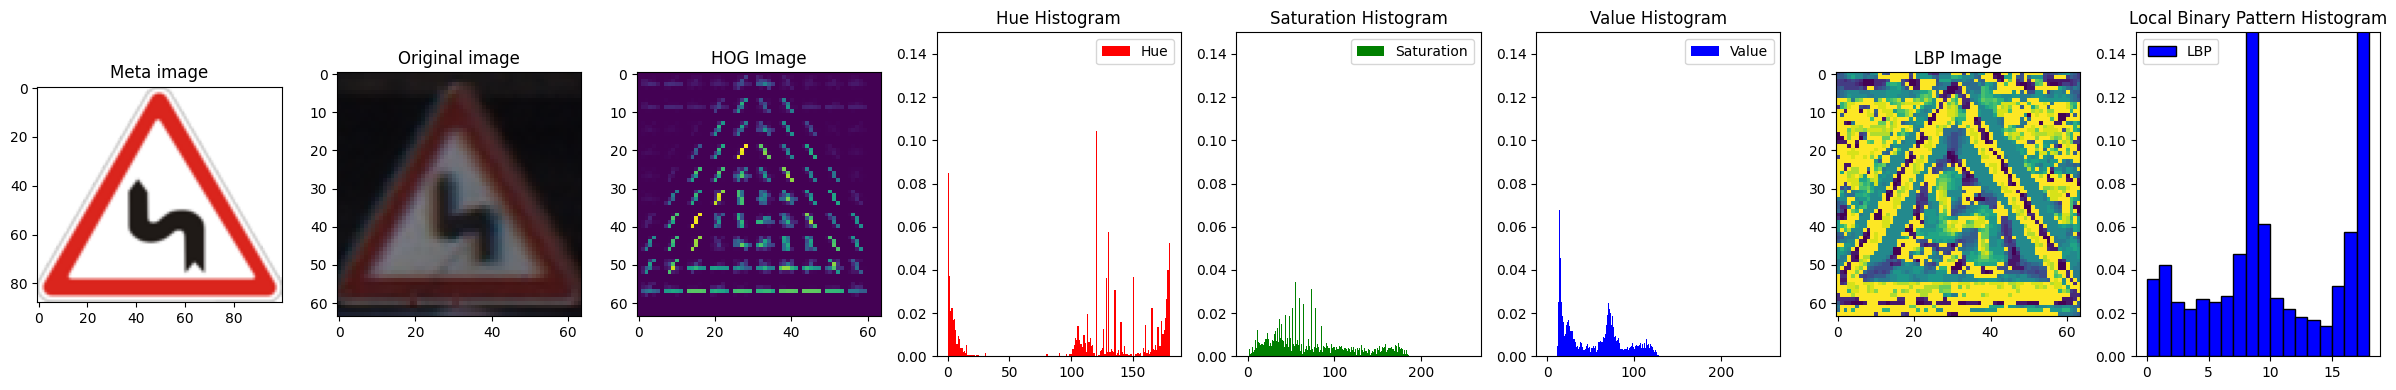

Class: 22 Description: Uneven road surface


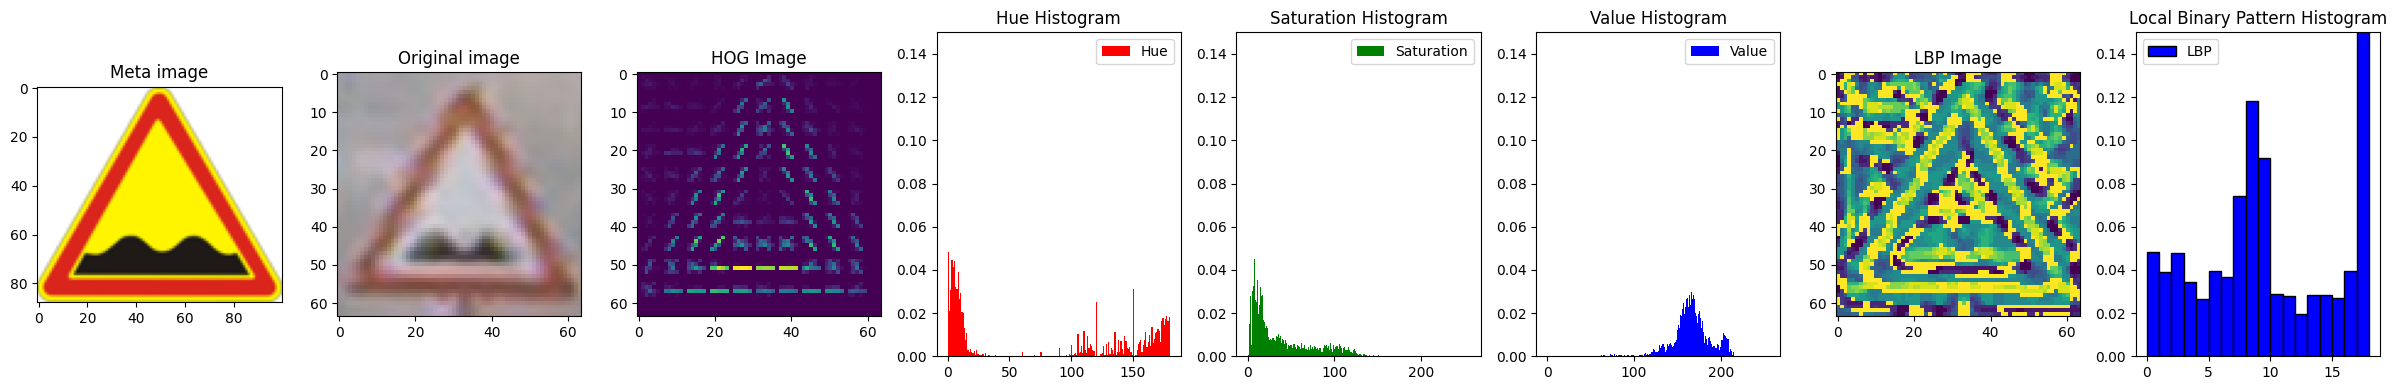

Class: 23 Description: Slippery when wet/dirty


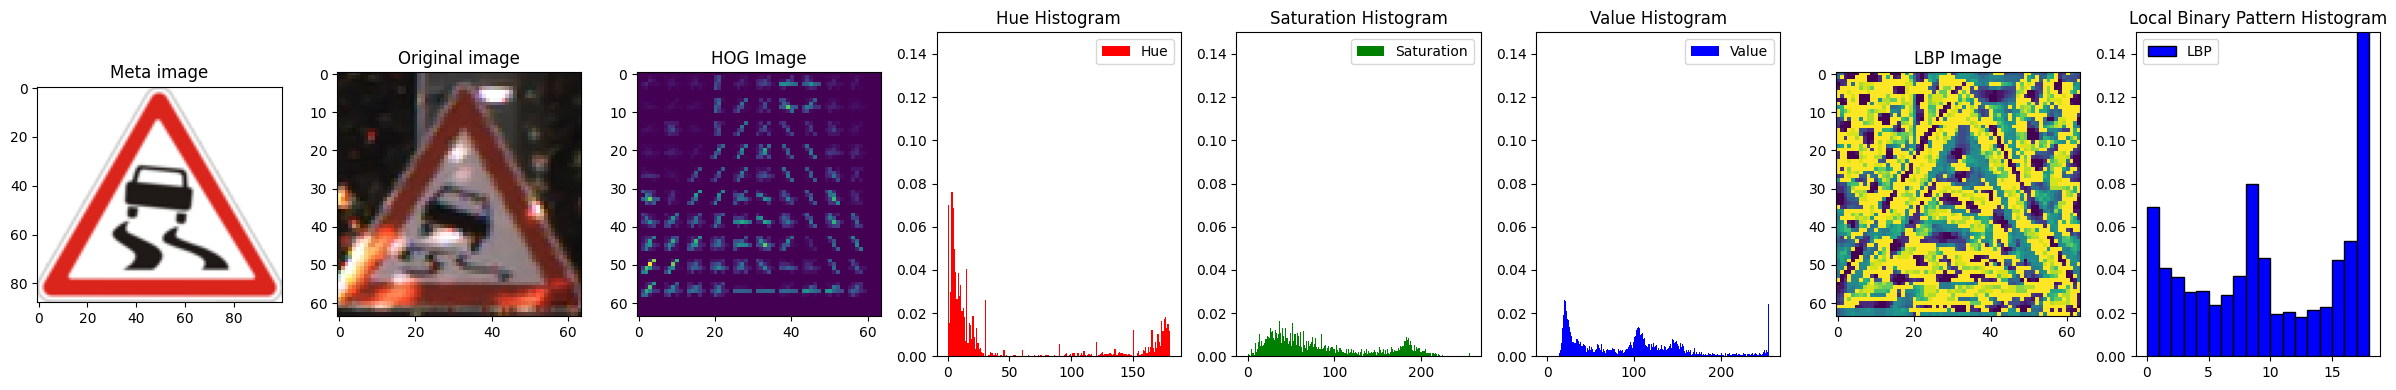

Class: 24 Description: Road narrows


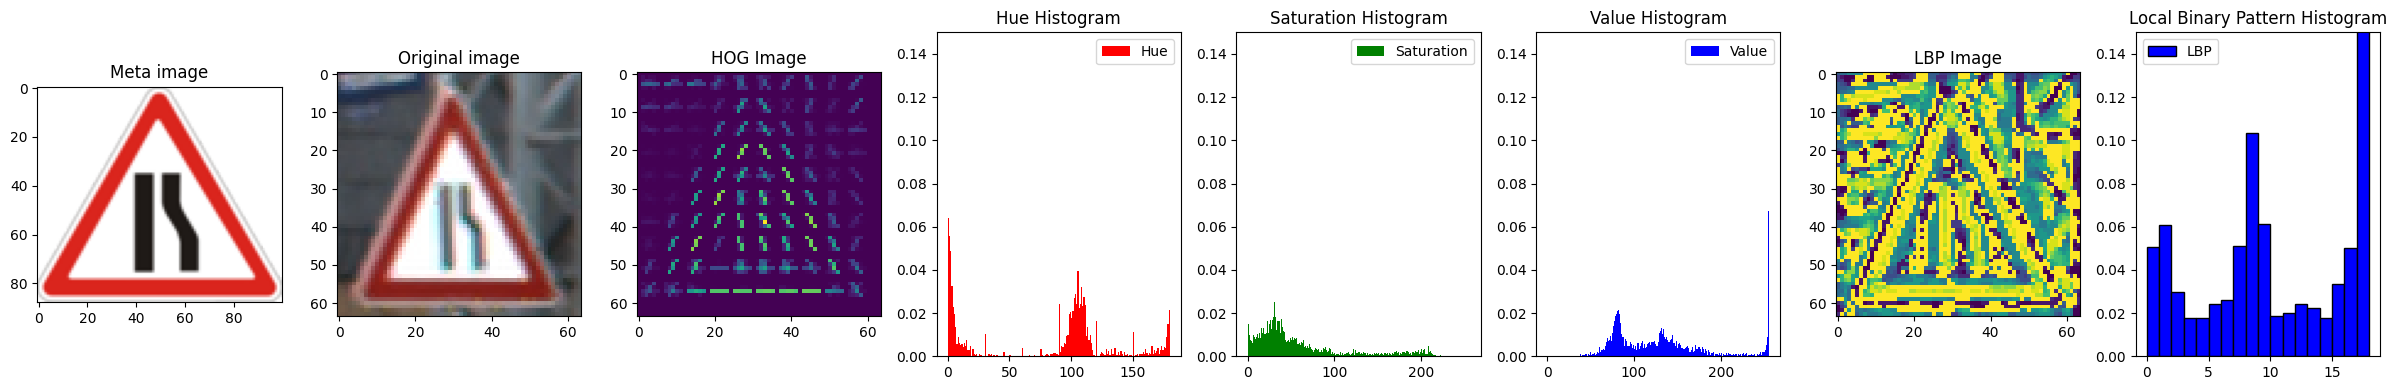

Class: 25 Description: Roadworks


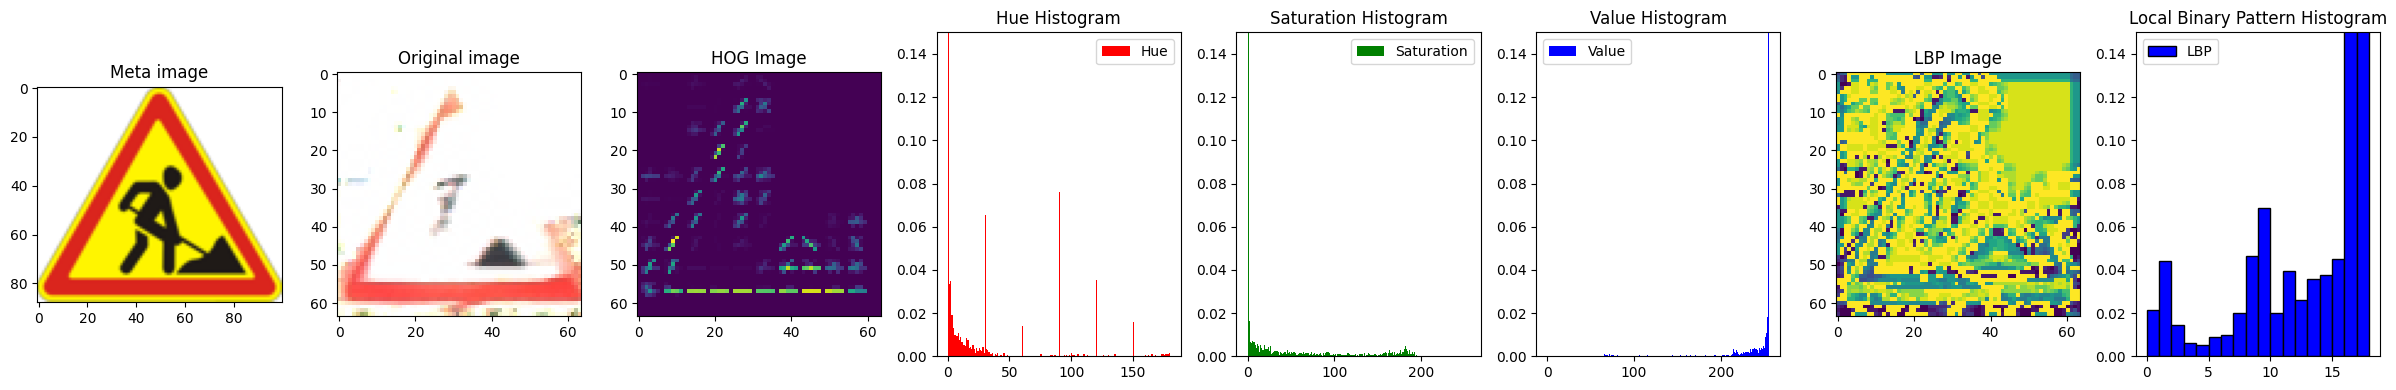

Class: 26 Description: Traffic signals ahead


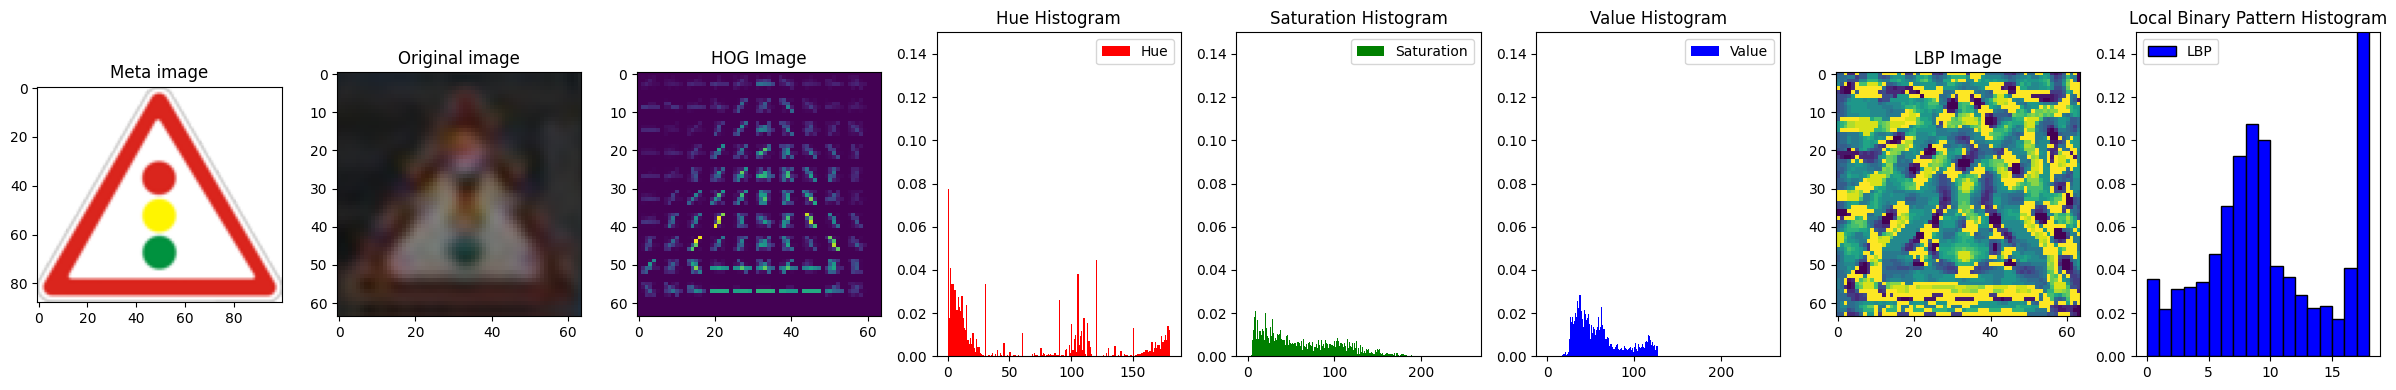

Class: 27 Description: Pedestrian crossing


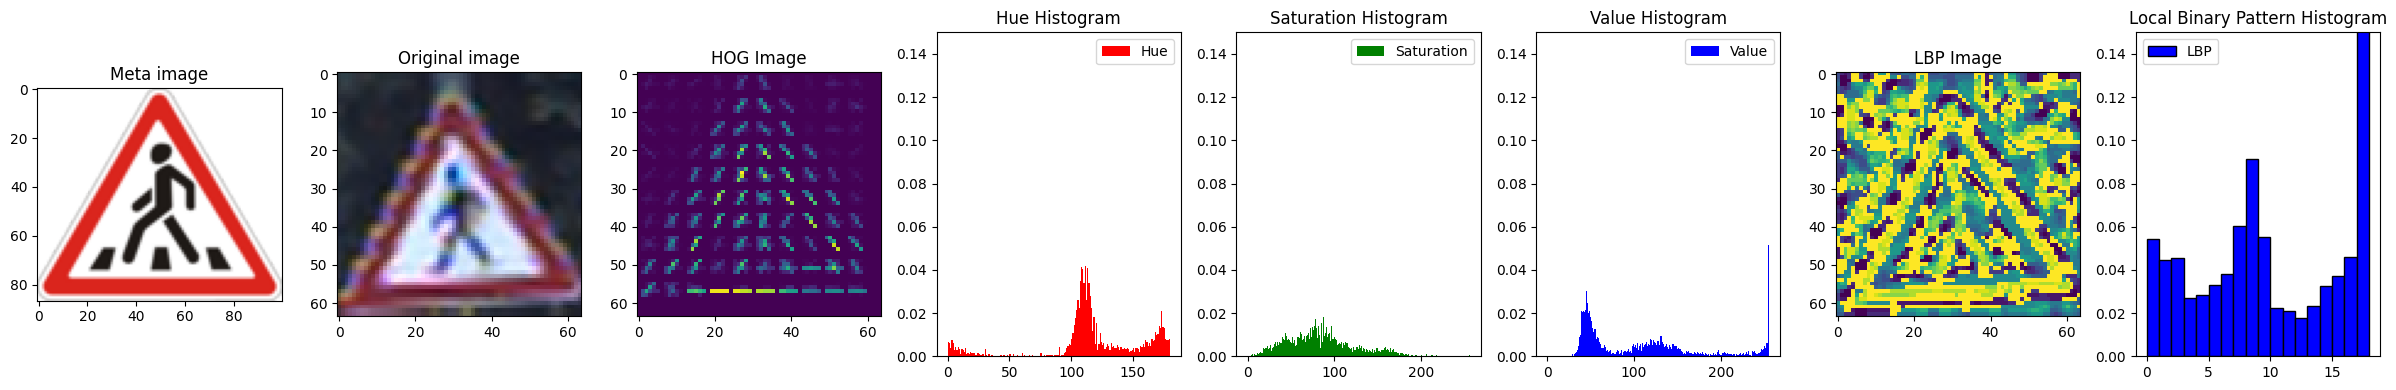

Class: 28 Description: Watch for children


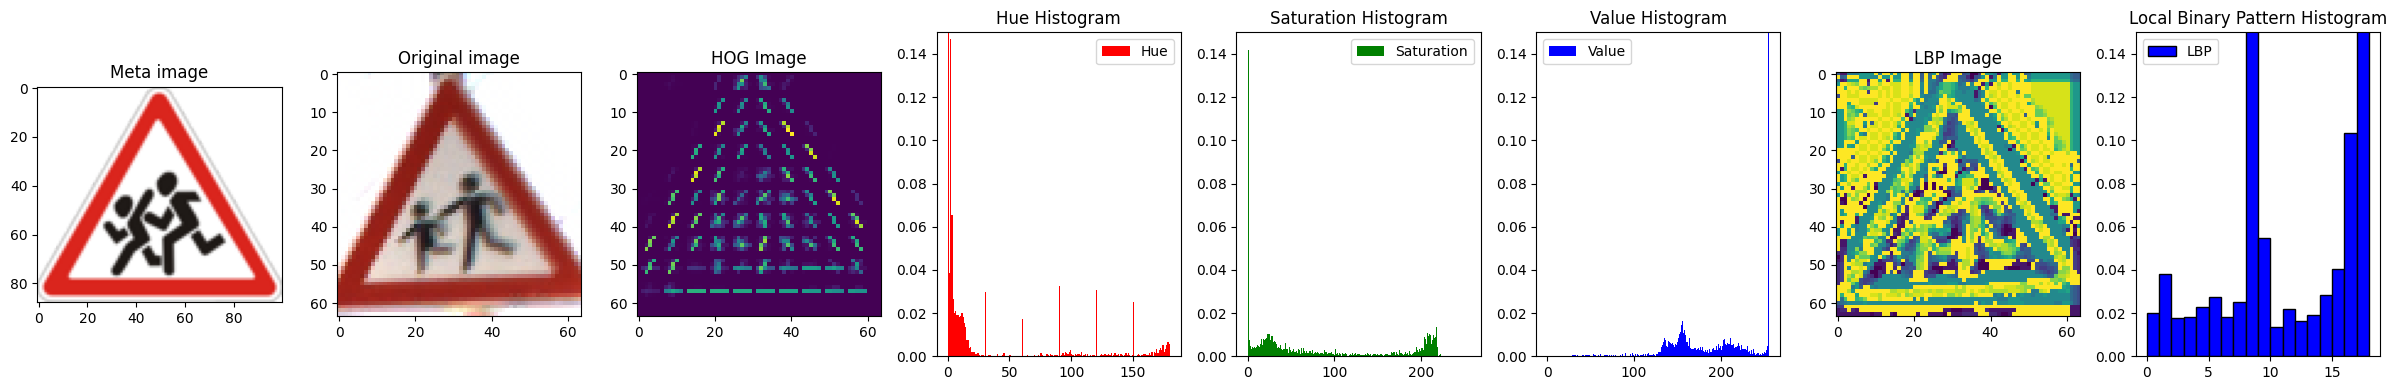

Class: 29 Description: Bicycle crossing


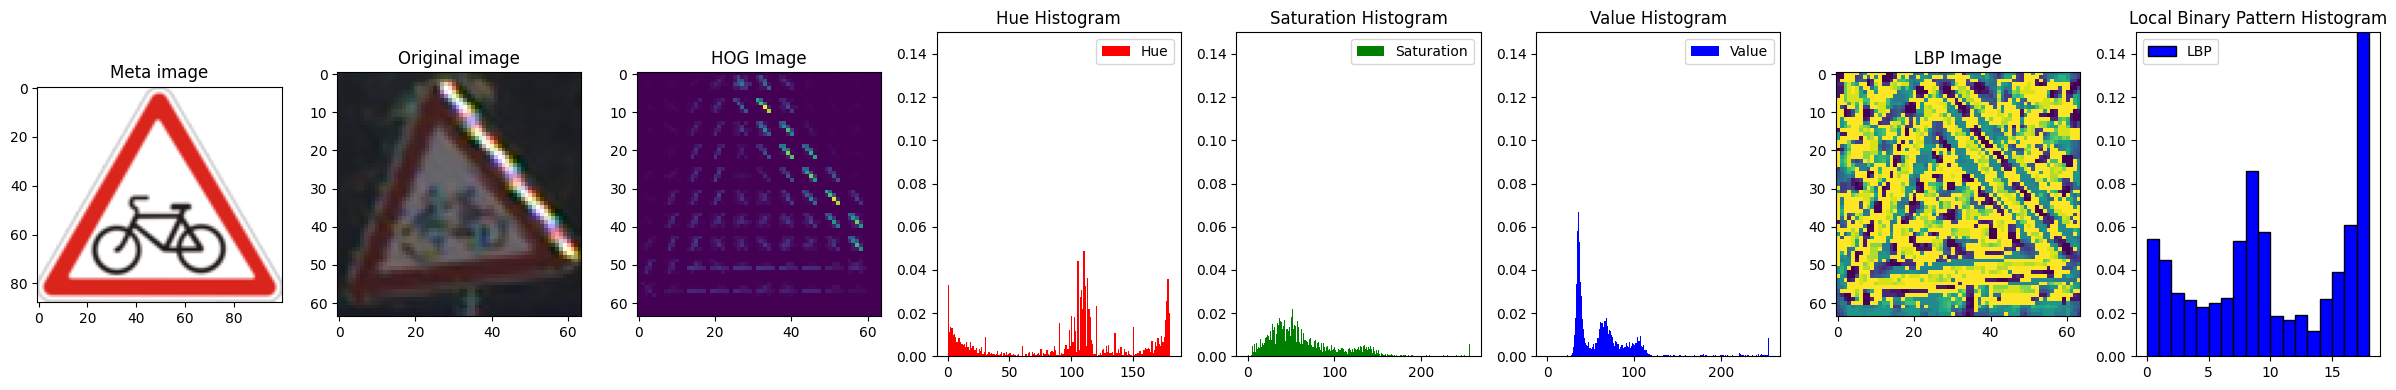

Class: 30 Description: Ice/snow road ahead


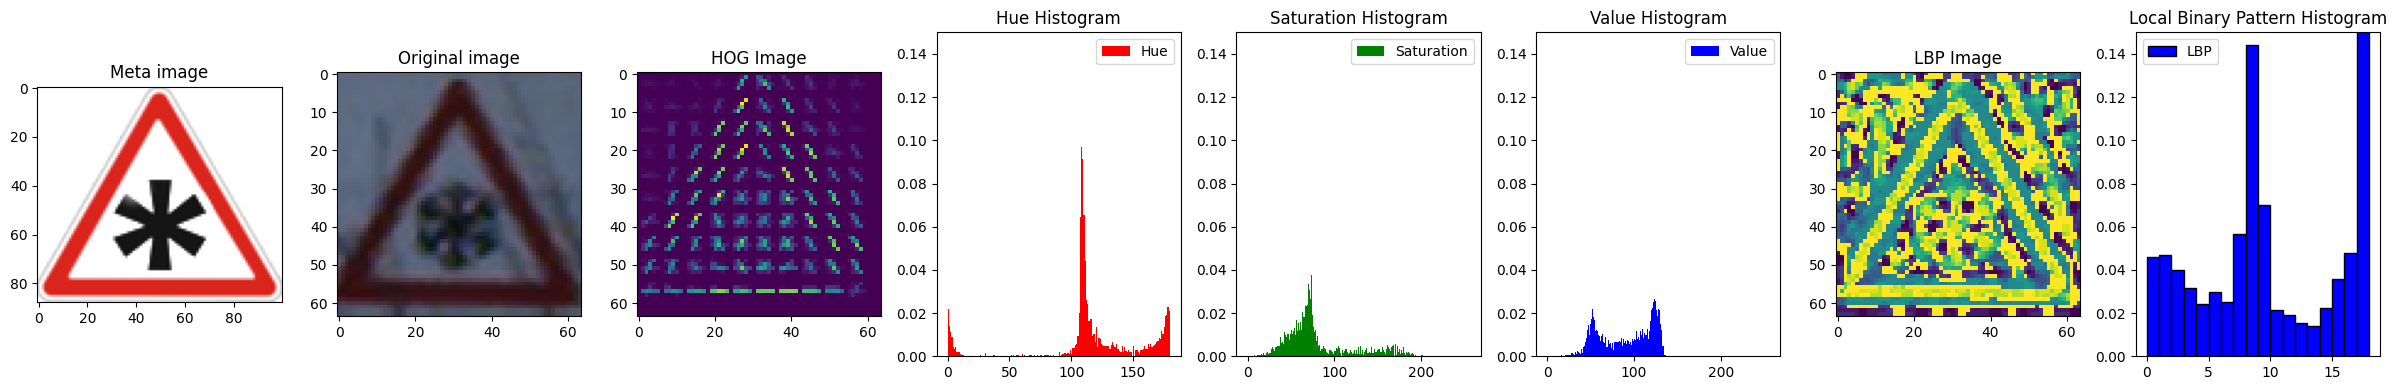

Class: 31 Description: Wild animal crossing


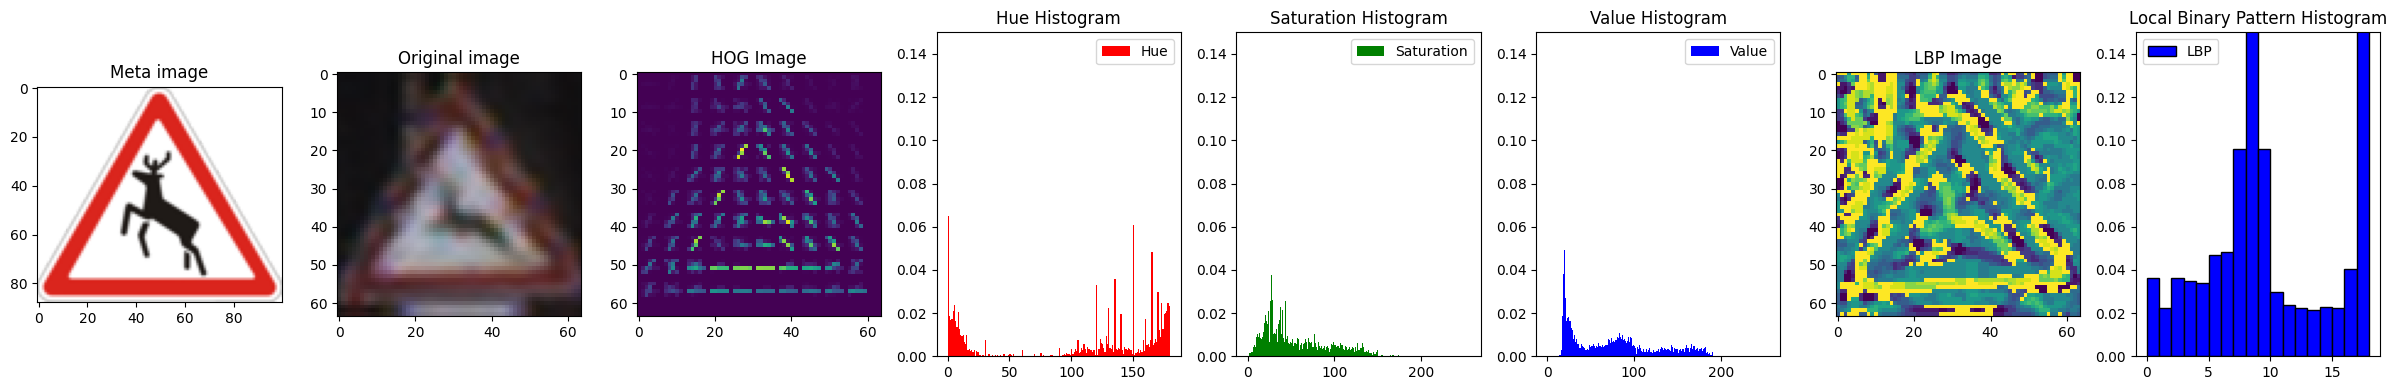

Class: 32 Description: End of all restrictions


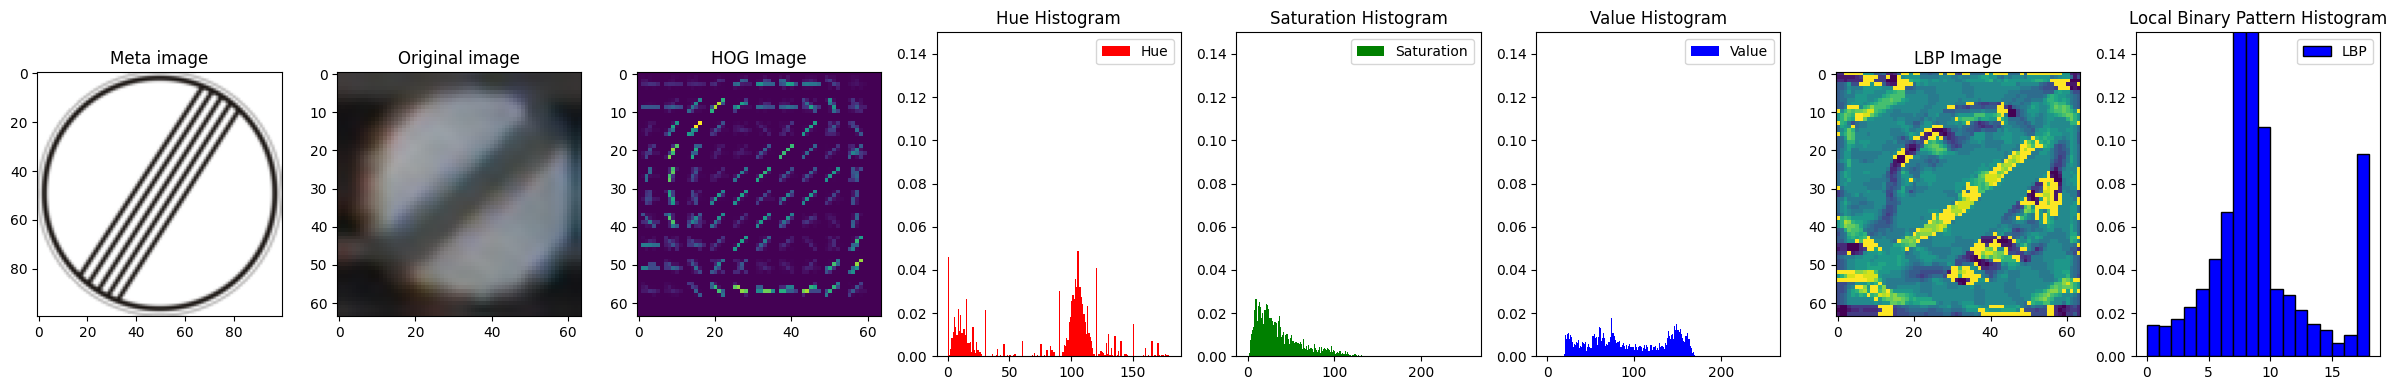

Class: 33 Description: Turn right ahead


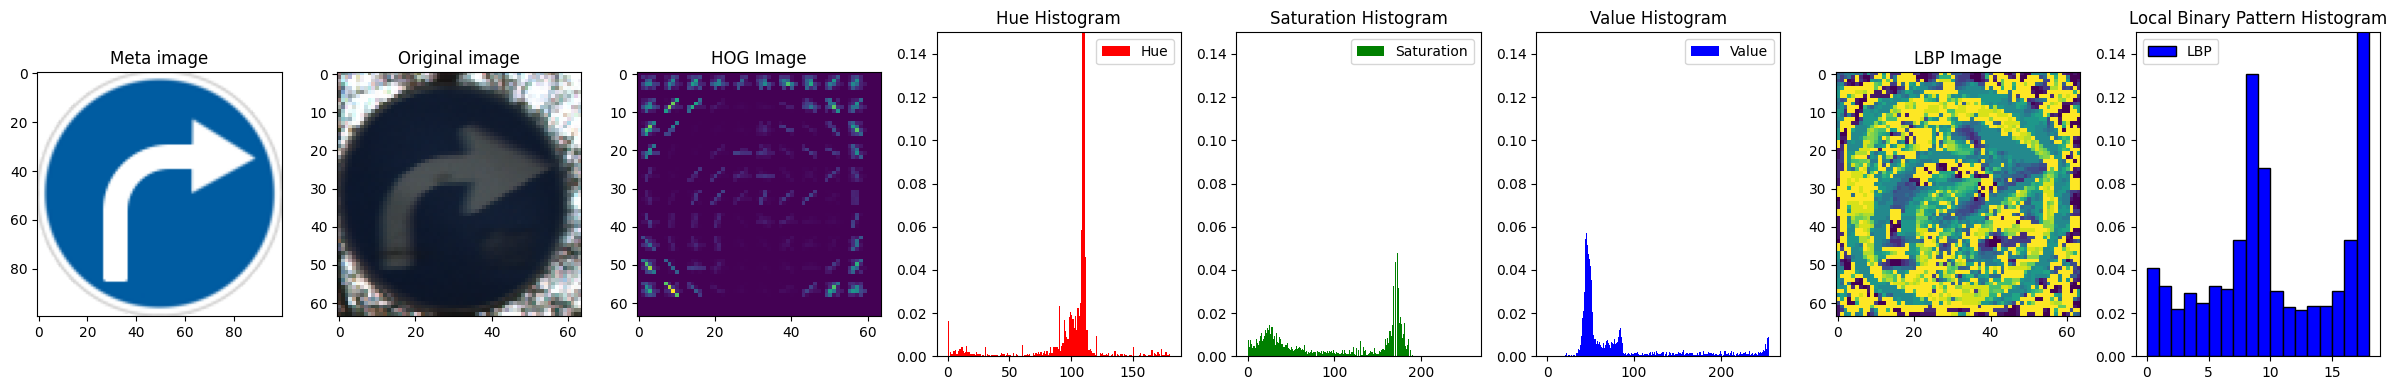

Class: 34 Description: Turn left ahead


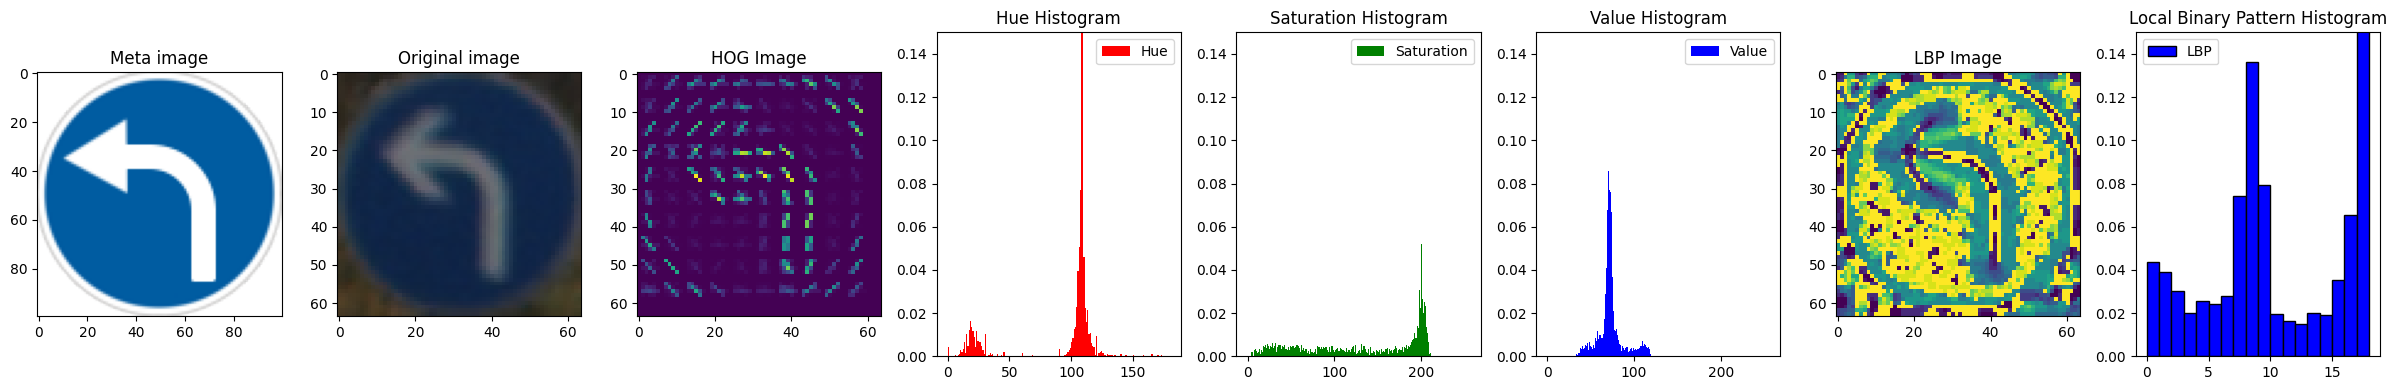

Class: 35 Description: Ahead only


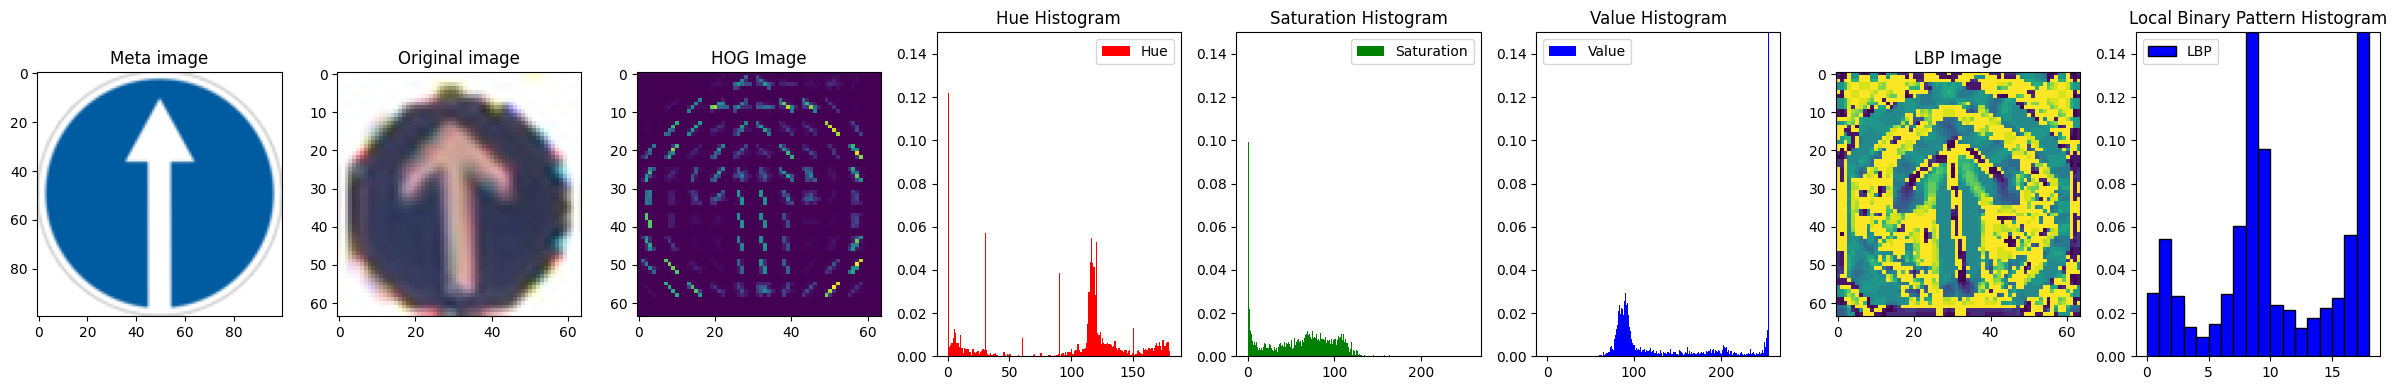

Class: 36 Description: Ahead or turn right only


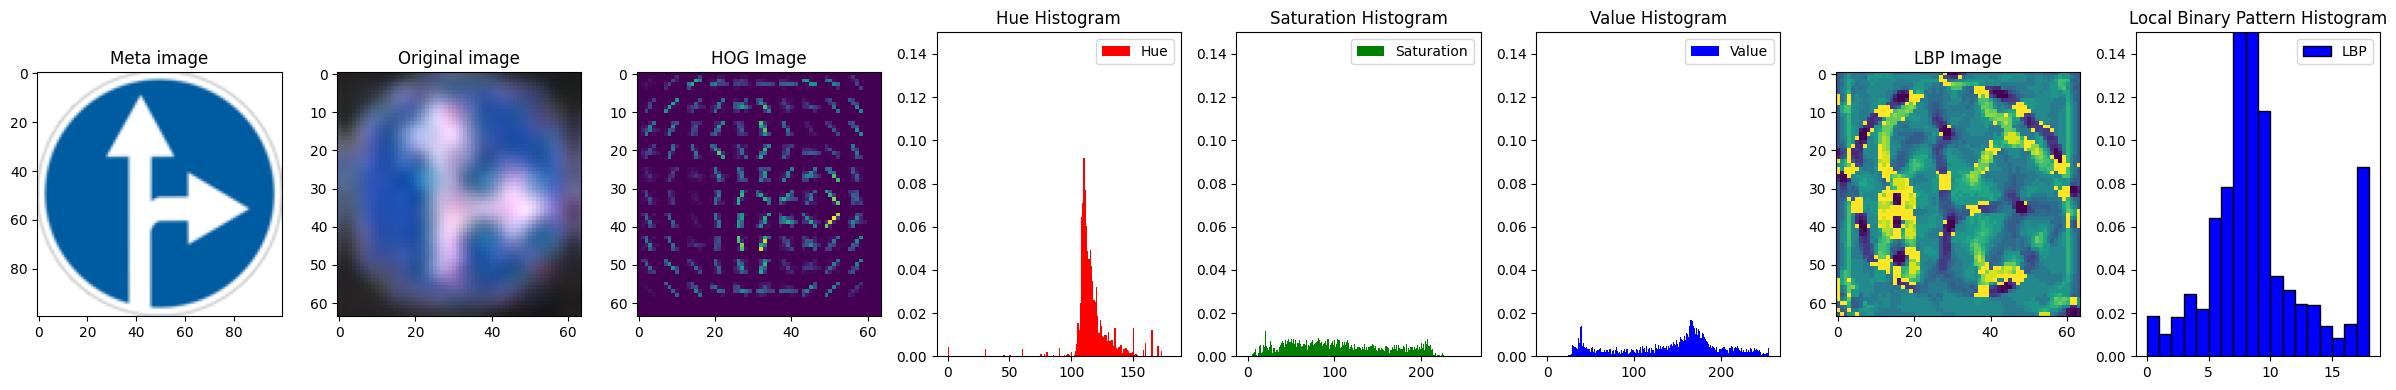

Class: 37 Description: Ahead or left turn only


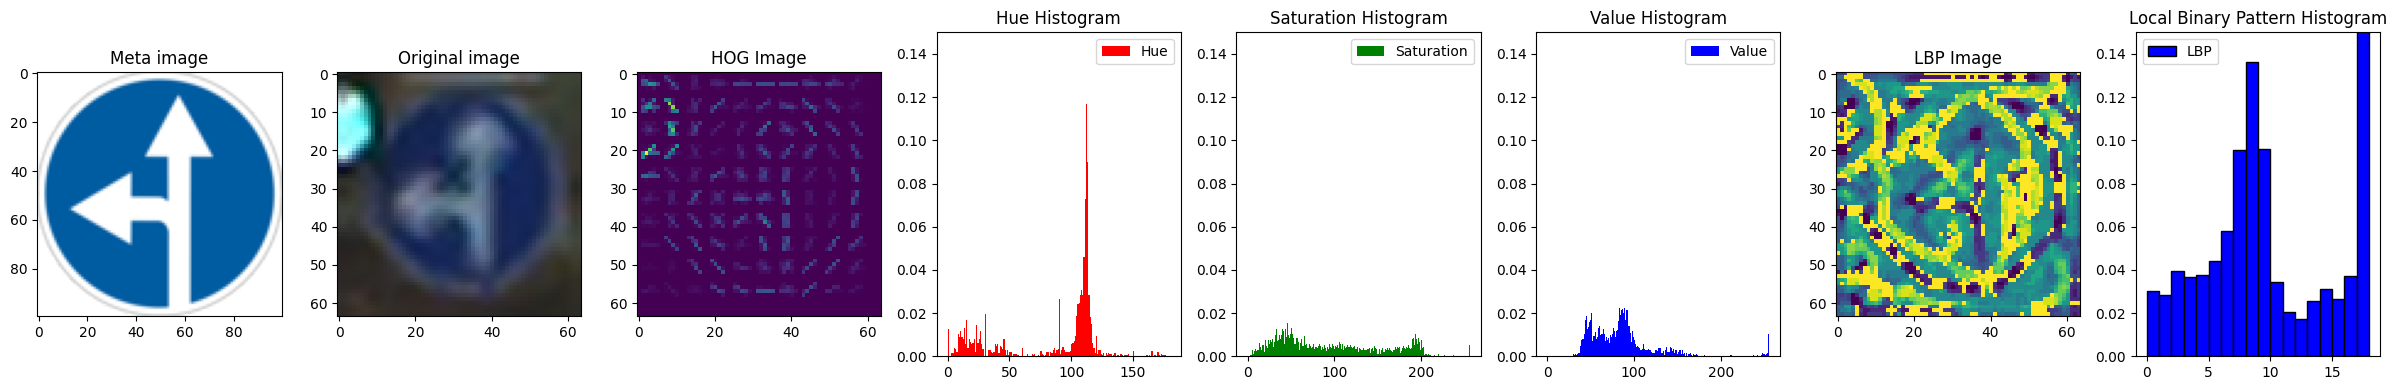

Class: 38 Description: Pass by on right


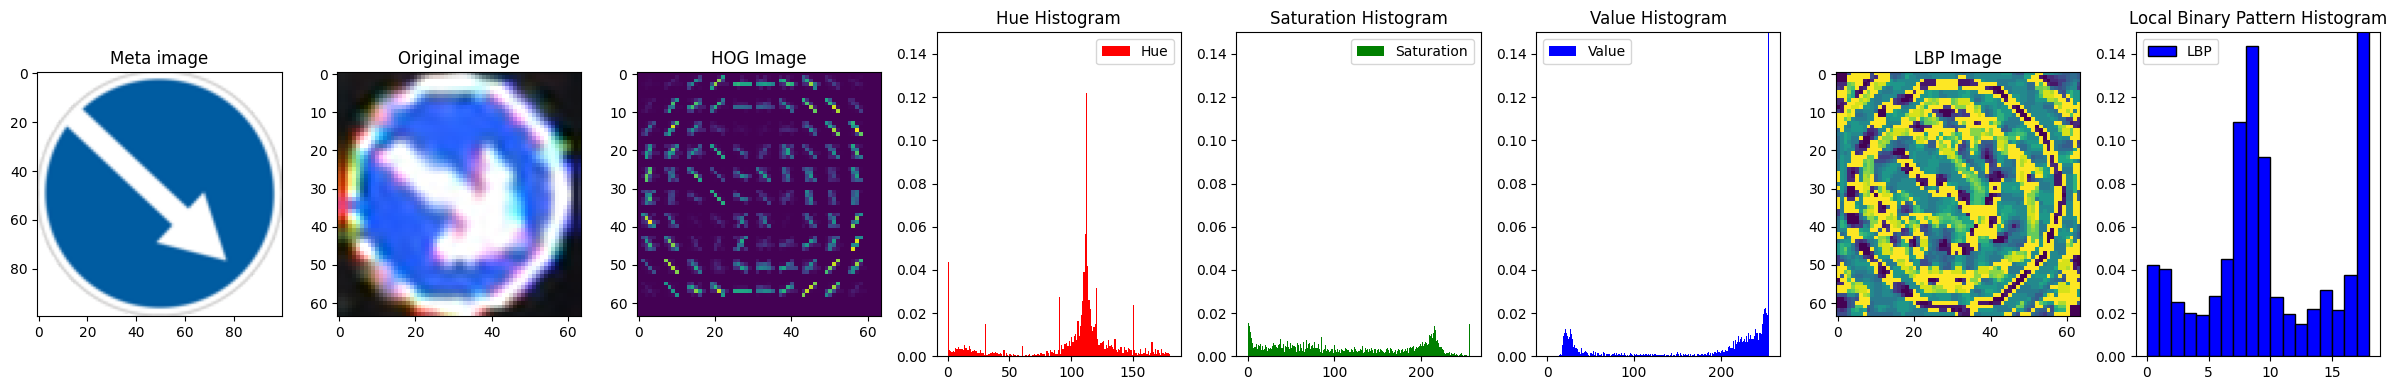

Class: 39 Description: Pass by on left


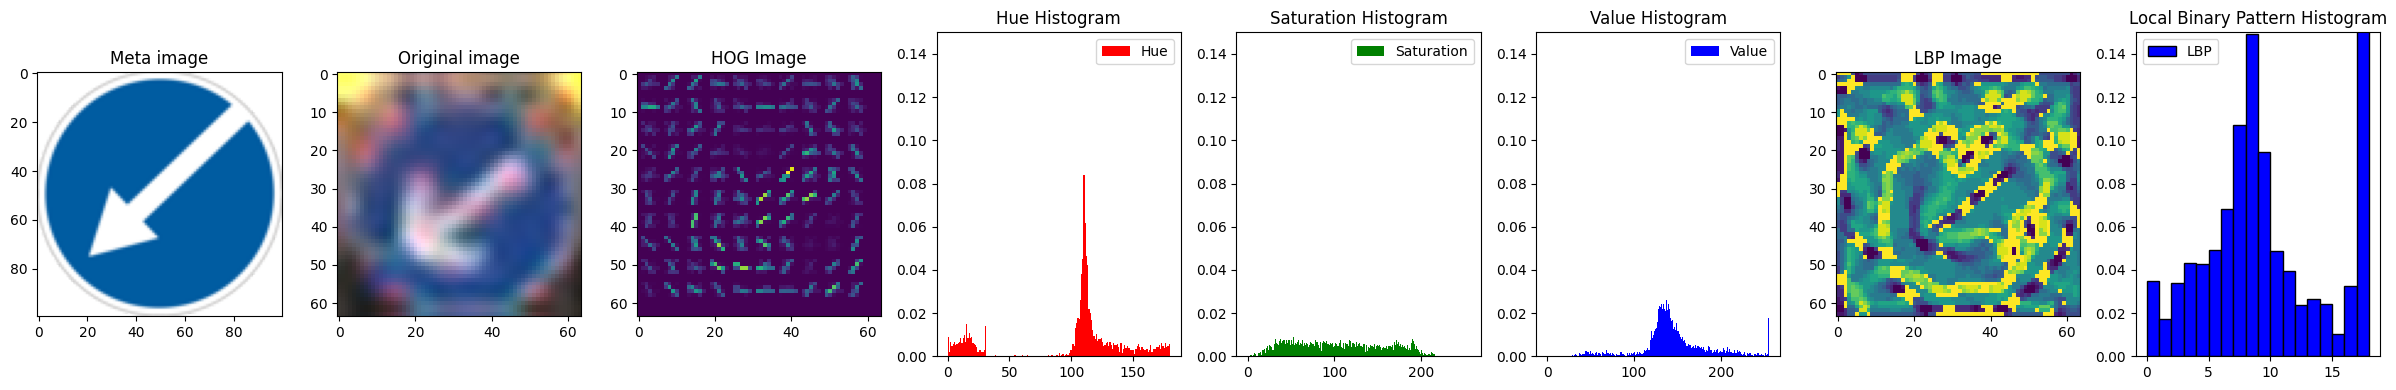

Class: 40 Description: Round about


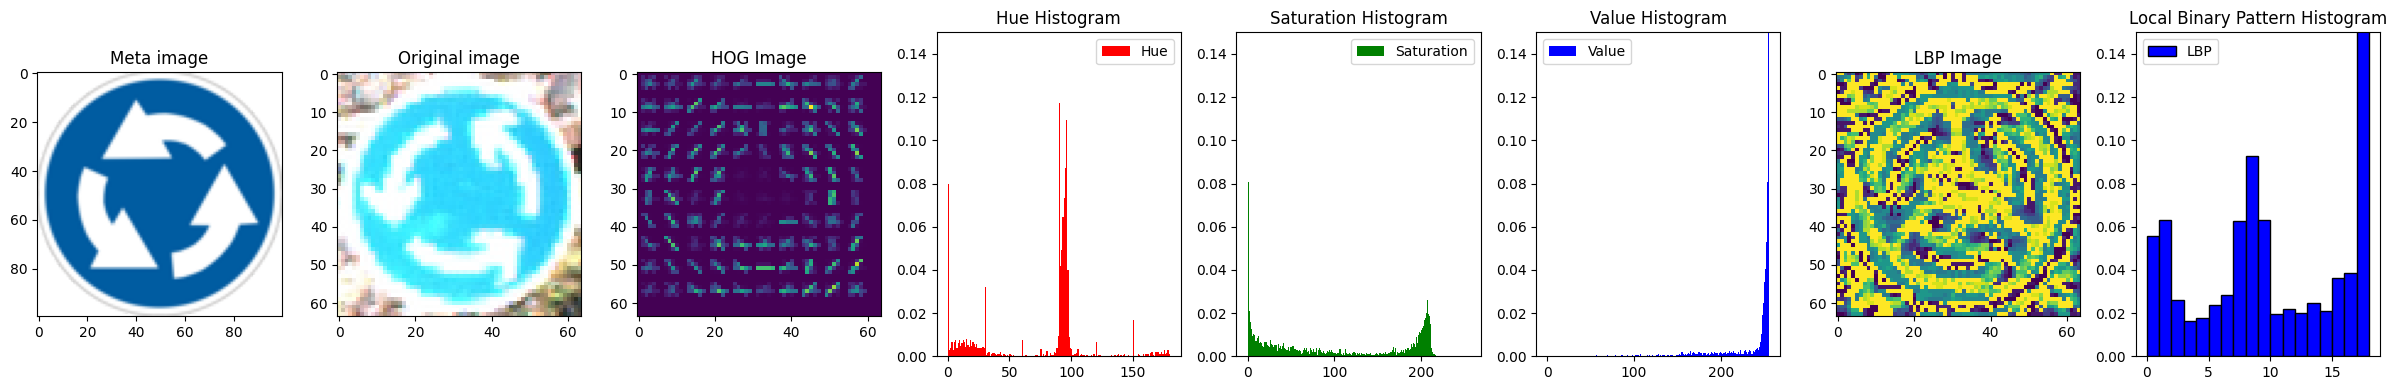

Class: 41 Description: End of no passing zone


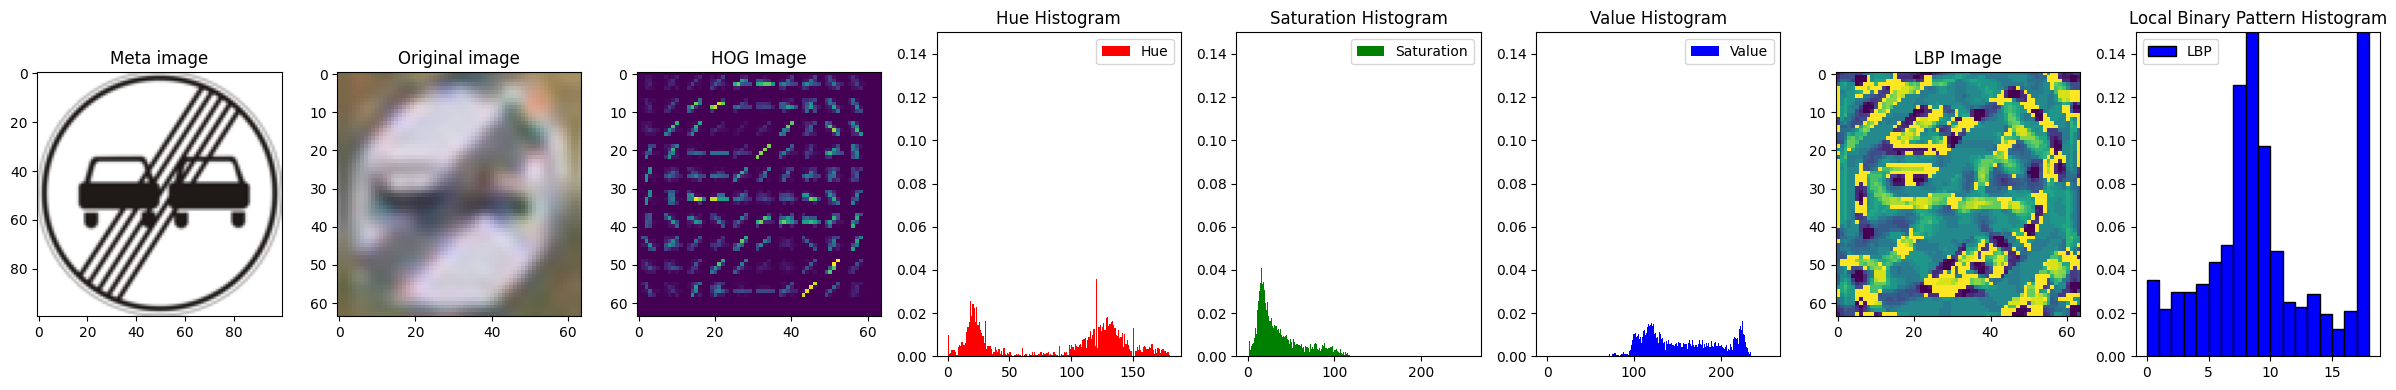

Class: 42 Description: End of no passing zone for trucks


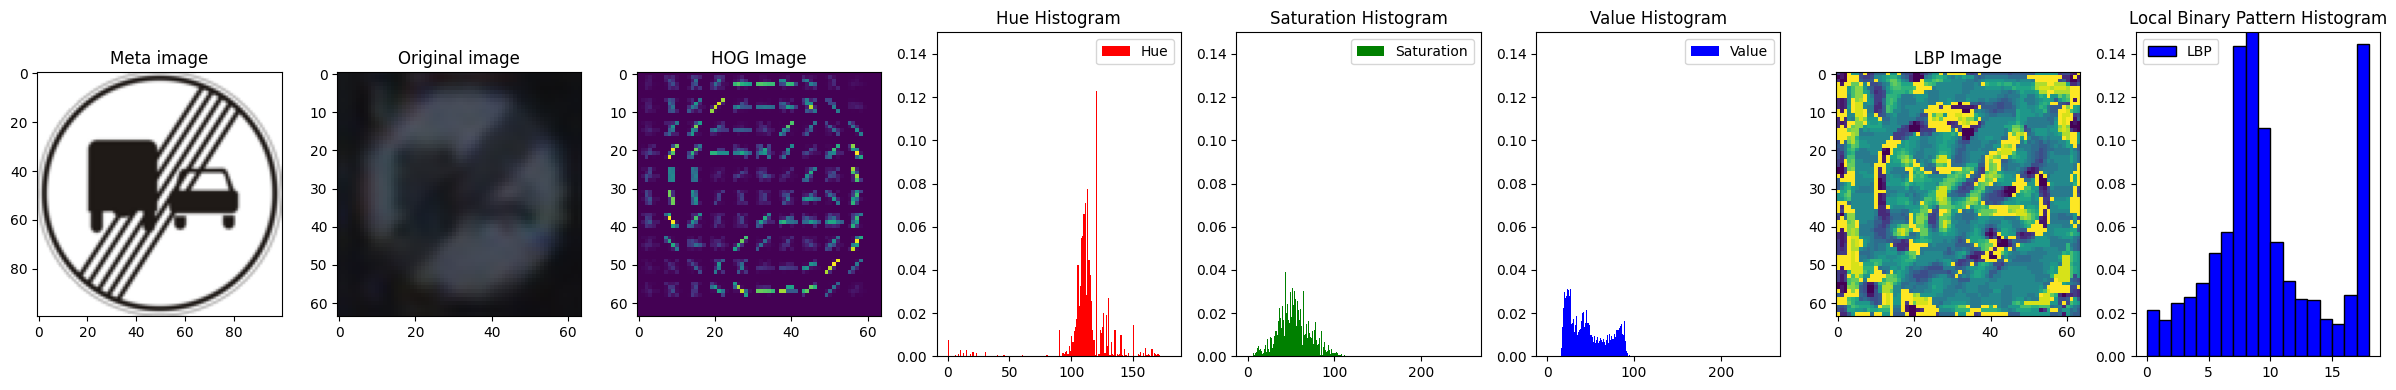

In [131]:
h_ymin = 0
h_ymax = (
    0.15  # This will clip some high values but provide better overall visualization
)
random_seed = 42
num_samples_per_class = 1
for i in range(43):
    class_members = dft.filter(pl.col("ClassId") == i)
    samples = class_members.sample(
        num_samples_per_class, with_replacement=False, seed=random_seed
    )

    print(132 * "=")
    print(f"Class: {i} Description: {samples['Description'][0]}")

    for j, sample in enumerate(samples.iter_rows(named=True)):
        fig = plt.figure(figsize=(24, 4))
        nrows = 1
        ncols = 8

        ########################################################################
        # Plot original image
        original_image = np.load(BytesIO(sample["Meta_Image"]))
        original_image = (original_image * 255).astype(np.uint8)
        ax = fig.add_subplot(nrows, ncols, 1)
        ax.imshow(original_image)
        ax.set_title("Meta image")

        ########################################################################
        # Plot original image
        original_image = np.load(BytesIO(sample["Image"]))
        original_image = (original_image * 255).astype(np.uint8)
        ax = fig.add_subplot(nrows, ncols, 2)
        ax.imshow(original_image)
        ax.set_title("Original image")

        ########################################################################
        # Plot Hog Image
        hog_image = np.load(BytesIO(sample["HOG_Image"]))
        ax = fig.add_subplot(nrows, ncols, 3)
        ax.imshow(hog_image)
        ax.set_title("HOG Image")

        ########################################################################
        # Plot Hue Histogram
        hue_hist = np.asarray(sample["Hue_Hist"])
        hue_edges = np.histogram_bin_edges(hue_hist, bins=180, range=(0, 180))
        hue_centers = 0.5 * (hue_edges[1:] + hue_edges[:-1])
        hue_normalized = normalize_histogram(hue_hist)
        ax = fig.add_subplot(nrows, ncols, 4)
        plt.bar(
            hue_centers,
            hue_normalized,
            width=(hue_edges[1] - hue_edges[0]),
            color="red",
            label="Hue",
        )
        ax.set_ylim(ymin=h_ymin, ymax=h_ymax)
        ax.legend()
        ax.set_title("Hue Histogram")

        ########################################################################
        # Plot Saturation Histogram
        sat_hist = np.asarray(sample["Saturation_Hist"])
        sat_edges = np.histogram_bin_edges(sat_hist, bins=256, range=(0, 256))
        sat_centers = 0.5 * (sat_edges[1:] + sat_edges[:-1])
        sat_normalized = normalize_histogram(sat_hist)
        ax = fig.add_subplot(nrows, ncols, 5)
        plt.bar(
            sat_centers,
            sat_normalized,
            width=(sat_edges[1] - sat_edges[0]),
            color="green",
            label="Saturation",
        )
        ax.set_ylim(ymin=h_ymin, ymax=h_ymax)
        ax.legend()
        ax.set_title("Saturation Histogram")

        ########################################################################
        # Plot Value Histogram
        val_hist = np.asarray(sample["Value_Hist"])
        val_edges = np.histogram_bin_edges(val_hist, bins=256, range=(0, 256))
        val_centers = 0.5 * (val_edges[1:] + val_edges[:-1])
        val_normalized = normalize_histogram(val_hist)
        ax = fig.add_subplot(nrows, ncols, 6)
        plt.bar(
            val_centers,
            val_normalized,
            width=(val_edges[1] - val_edges[0]),
            color="blue",
            label="Value",
        )
        ax.set_ylim(ymin=h_ymin, ymax=h_ymax)
        ax.legend()
        ax.set_title("Value Histogram")

        ########################################################################
        # Plot LBP Image
        lbp_image = np.load(BytesIO(sample["LBP_Image"]))
        ax = fig.add_subplot(nrows, ncols, 7)
        ax.imshow(lbp_image)
        ax.set_title("LBP Image")

        ########################################################################
        # Plot LBP Histogram
        lbp_hist = np.array(sample["LBP_Hist"])
        lbp_edges = np.histogram_bin_edges(lbp_hist, bins=18, range=(0, 18))
        lbp_normalized_hist = normalize_histogram(lbp_hist)
        lbp_centers = 0.5 * (lbp_edges[1:] + lbp_edges[:-1])
        ax = fig.add_subplot(nrows, ncols, 8)
        plt.bar(
            lbp_centers,
            lbp_normalized_hist,
            width=(lbp_edges[1] - lbp_edges[0]),
            color="blue",
            edgecolor="black",
            label="LBP",
        )
        ax.set_ylim(ymin=h_ymin, ymax=h_ymax)
        ax.legend()
        ax.set_title("Local Binary Pattern Histogram")

        plt.tight_layout()
        plt.show()